In this part of the course, we'll dig down into financial markets, showing where you can get various datasets for analytical work. The first step is to understand the types of datasets which are out there! Before we do that, let us set all the various API keys we'll need later for the data sources we'll use (Quandl and FRED/ALFRED in particular). Note, that you'll need to get your own API keys to use. We'll also import a few other libraries we'll need in the course of this notebook as well for charting, loading data and calculations on that data.

In [2]:
import os

# So we don't see deprecated warnings... when you're coding it's usually good to leave these!
import warnings
warnings.filterwarnings('ignore')

# Disable logging messages, to make output tidier
import logging
import sys
logging.disable(sys.maxsize)

# For time series and matrix calculations
import pandas as pd
import numpy as np

# To make sure our Matplotlib plots are put inside the notebook
%matplotlib inline

# For plotly
import plotly.offline as py_offline

import plotly.io as pio
pio.renderers.default = "notebook" # larger notebook files, but interactive plots
# pio.renderers.default = "svg"
# pio.renderers.default = "png" # smaller notebook files

# py_offline.init_notebook_mode() # for plotly before 4.0 to ensure plot is published in Jupyter notebook

# Chartpy visualization tools
from chartpy import Chart, Style

# note you might need to create this folder or change it!
raw_data_path = ''

# For downloading market data
import quandl

# Either set API keys as an environment variable (preferred for security reasons) 
# or easier to just replace these below, with your own keys (if you aren't sharing your notebooks)
try:
    QUANDL_API_KEY = os.environ['QUANDL_API_KEY']
    FRED_API_KEY = os.environ['FRED_API_KEY']
    ALPHA_VANTAGE_API_KEY = os.environ['ALPHA_VANTAGE_API_KEY']
    EIKON_API_KEY = os.environ['EIKON_API_KEY']
except:
    pass

from findatapy.market import Market, MarketDataGenerator, MarketDataRequest

# Check if Bloomberg if installed (to check whether to run)
bbg_installed = False

try:
    import blpapi
    bbg_installed = True
except:
    pass

# Define if Eikon is installed (to check whether to run)
eikon_installed = False

## Different types of data

### Market data

The most important dataset for traders is market data, in other words the prices of assets. Some data can relate to actual trades that have been executed between two counterparties, whether that is on an exchange or an over-the-counter basis. Other data can relate to quotes supplied by market makers. Essentially, a market maker posts a quote to buy or sell an asset (and an amount that they are willing to transact at that price. They will post bid quotes, where they are willing to buy, and ask quotes where they are willing to sell.

A market taker can then take liquidity by transacting with the market maker. If the market taker wants to buy from a market maker, they'll transact at the higher ask quote. By contrast, if a market maker will sell to the market maker they will do so at the lower bid quote. Essentially, the market maker is providing a service (liquidity), and hence need to be compensated for that. This is why we have the spread between the bid and ask.  

The equities market is generally traded on exchanges, where buyers and sellers are matched. It can be the case that multiple exchanges can trade the same equity. By constrast other markets like currencies, tend to be traded more on an over-the-counter basis. In this instance, transactions will occur on a billateral basis, without an exchange matching orders. There are also ECN (electronic connection networks), which are similar to exchanges. Market data is essentially "exhaust data" which is the result of all these.

### Economic data

Data about the economic is also used by market participants to help make trading decisions. A lot of this data will be published by governmental statistical organisations and central banks. Hard data is those datasets which represent historic economic activity. Data firms all publish a large amount of survey based economic data (eg. PMIs, which is typically known as soft data and is more forward looking). Economic data can typically be split into several groups, which are listed below.

* Growth data - eg. GDP
* Labor data - eg. Unemployment Rate, Change in nonfarm payrolls
* Inflation data - eg. CPI and PPI
* Consumer data - eg. Consumer Confidence
* Industrial data - eg. Industrial Production

### Company data

Public companies have to publish their results on a regular basis to the market, usually quarterly (or twice a year). Their earnings report will give an indication of their revenues, their profit, their balance sheet etc. Equities traders will use this data to construct factor based trading strategies. An interesting source of earning per share data and crowdsourced estimates for these is https://www.estimize.com/ (you will need to sign-up for a free account).

### Alternative data

That's it right? Not really! So far we've talked about the typical sorts of datasets that used by market participants. There are also many alternative datasets that can be used to shed insight into markets. In many cases, these datasets won't necessarily be sourced within finance.  It can be in unusual data types, such as text or images. Furthermore, it often doesn't have a lot of structure associated with it. Often we need to structure the data to more it usable. 

### Structured vs. unstructured data

Structured data consists of nicely formatted data. Time series of price data, can be viewed as a common example of structured data. Price data tends to follow a relatively consistent format. Let's now think about web pages. They are generally formatted in many different ways. Furthermore the datasets are usually text based, rather than numerical. Hence, web content is typically referred to as unstructured data. In other words, it doesn't follow a common form. To understand web based data, we need to first read in the unstructured data. Then we need to clean it, removing unnecessary data, which isn't relevant for us. Then we need to structure it, into a more common form. 

Structuring often requires tagging content with additional fields, which can make it easier to understand. These additional tags for text based content are typically things like the timestamp of when it was written, tags relating to the topic of the text, sentiment of the text (is it good or bad?).

## Sources of market data and how to download

We shall detail a number of different data sources. Many data sources come with licence restrictions, in particular paid sources, where you can redistribute the raw data (and usually derived data cannot be redistributed either).  For free data sources, you can usually use for personal usage, but again there might be restrictions in using that data commercially or redistributing. Make sure you check licence terms before using data, to make sure you comply with their terms of usage. When in doubt, err on the side of caution. 

### findatapy - https://github.com/cuemacro/findatapy

findatapy isn't a data provider. It is Python based library which allows you to download market data from a number of different external data sources including Bloombreg, Quandl, FRED, Alpha Vantage, Yahoo, FXCM and DukasCopy (as well as a data from many cryptocurrency exchanges). You define your own mapping to your own tickers to those of the vendors as well, and store these on disk, so you don't have to remember vendor specific tickers. To install findatapy, you need to use `pip`, ie.:

    pip install git+https://github.com/cuemacro/findatapy.git

Or we can download without Git (which might be easier, although we won't always get the latest version):

    pip install findatapy

### Quandl - https://www.quandl.com (now Nasdaq Data Link - https://data.nasdaq.com/)

Nasdaq Data Link (formally Quandl) has many different datasets for financial markets, which include data from various market and economic databases. There are also many alternative datasets. There are a mixture of free and premium datasets on there. Whilst it has been rebranded at Nasdaq Data Link, the service is pretty similar.

We can manually download data via Nasdaq Data Link's website. Eg. for WTI data we can download this from https://data.nasdaq.com/data/EIA/PET_RWTC_D-Cushing-OK-WTI-Spot-Price-FOB-Daily and we'll briefly show you how to do this. Even though you'll likely end up downloading data via Python, it can be useful to browse Nasdaq Data Link's website to discover the types of datasets on there, and to find which tickers you want.

There is a Python based `quandl` package we can use to download data from Nasdaq Data Link into Pandas `DataFrame` objects. To install this use `pip`:

    pip install quandl
    
#### Plotting unemployment and crude prices

In our first example, we use the Quandl Python API directly to demonstrate how to automate data downloading. Our objective is to understand the relationship between the unemployment rate in Texas (which produces a lot of crude oil) and the price of WTI crude (West Texas Intermediate crude).

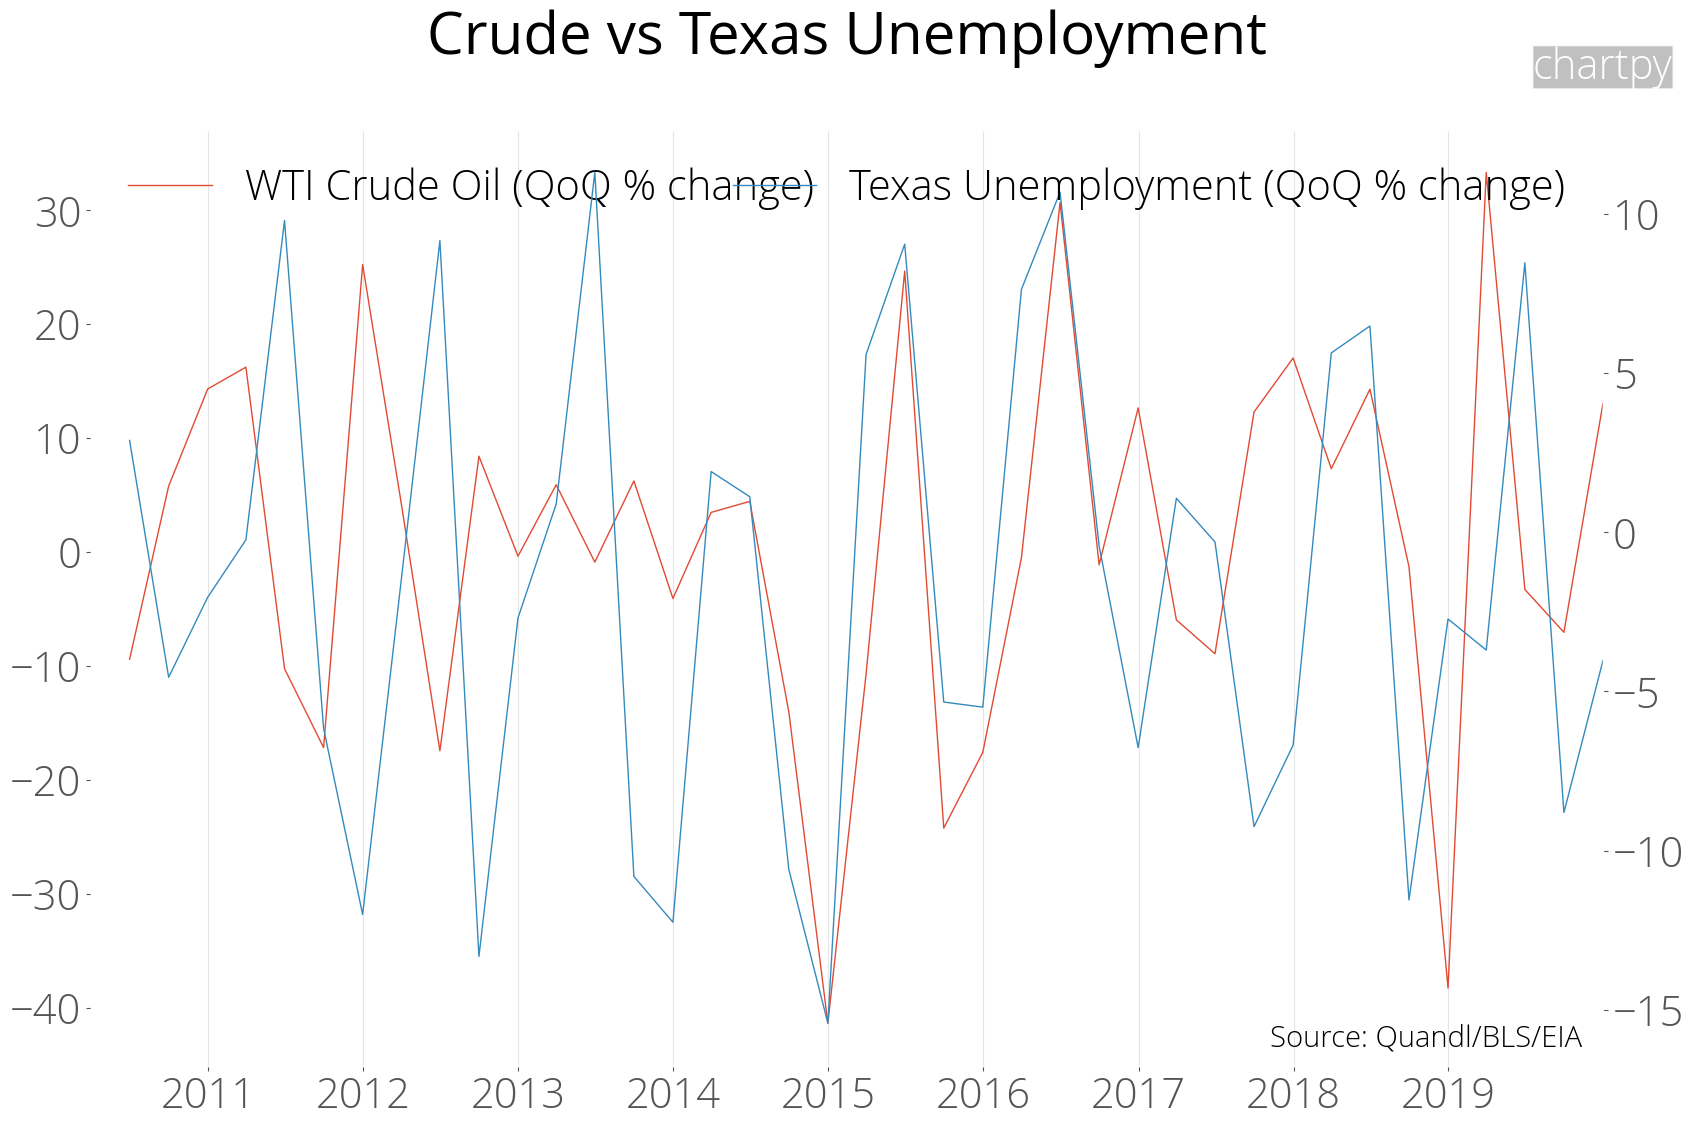

In [2]:
import quandl

quandl.ApiConfig.api_key = QUANDL_API_KEY

# Download data for WTI Crude oil from the EIA database on Quandl (US Department of Energy)
# We have looked up this ticker earlier on Quandl's website
df_wti = pd.DataFrame(quandl.get("EIA/PET_RWTC_D", start_date="2010-01-01", end_date="2019-12-31"))

# Work out the quarter on quarter changes (need to resample the data first!)
df_wti.columns = ['WTI Crude Oil (QoQ % change)']
df_wti = df_wti.resample('Q').last()
df_wti = (df_wti / df_wti.shift(1) - 1) * 100

# Download Texas unemployment data from the BLS database on Quandl (Bureau of Labor Statistics)
df_une = pd.DataFrame(quandl.get("BLSE/LAUST480000000000004", start_date="2010-01-01", end_date="2019-12-31"))
df_une.columns = ['Texas Unemployment (QoQ % change)']
df_une = df_une.resample('Q').last()
df_une = (df_une / df_une.shift(1) - 1) * 100

df = df_wti.join(df_une)

from chartpy import Style, Chart

# Use chartpy as it make it easier to use multiple y-axes!
style = Style(title='Crude vs Texas Unemployment', 
              y_axis_2_series='Texas Unemployment (QoQ % change)', 
              y_axis_showgrid=False, y_axis_2_showgrid=False, source='Quandl/BLS/EIA')
Chart(engine='matplotlib').plot(df, style=style)

We can instead use the `findatapy` API. The benefit of the `findatapy` API is that it looks similar whatever data source we are using, so we don't need to end up learning lots of different APIs.

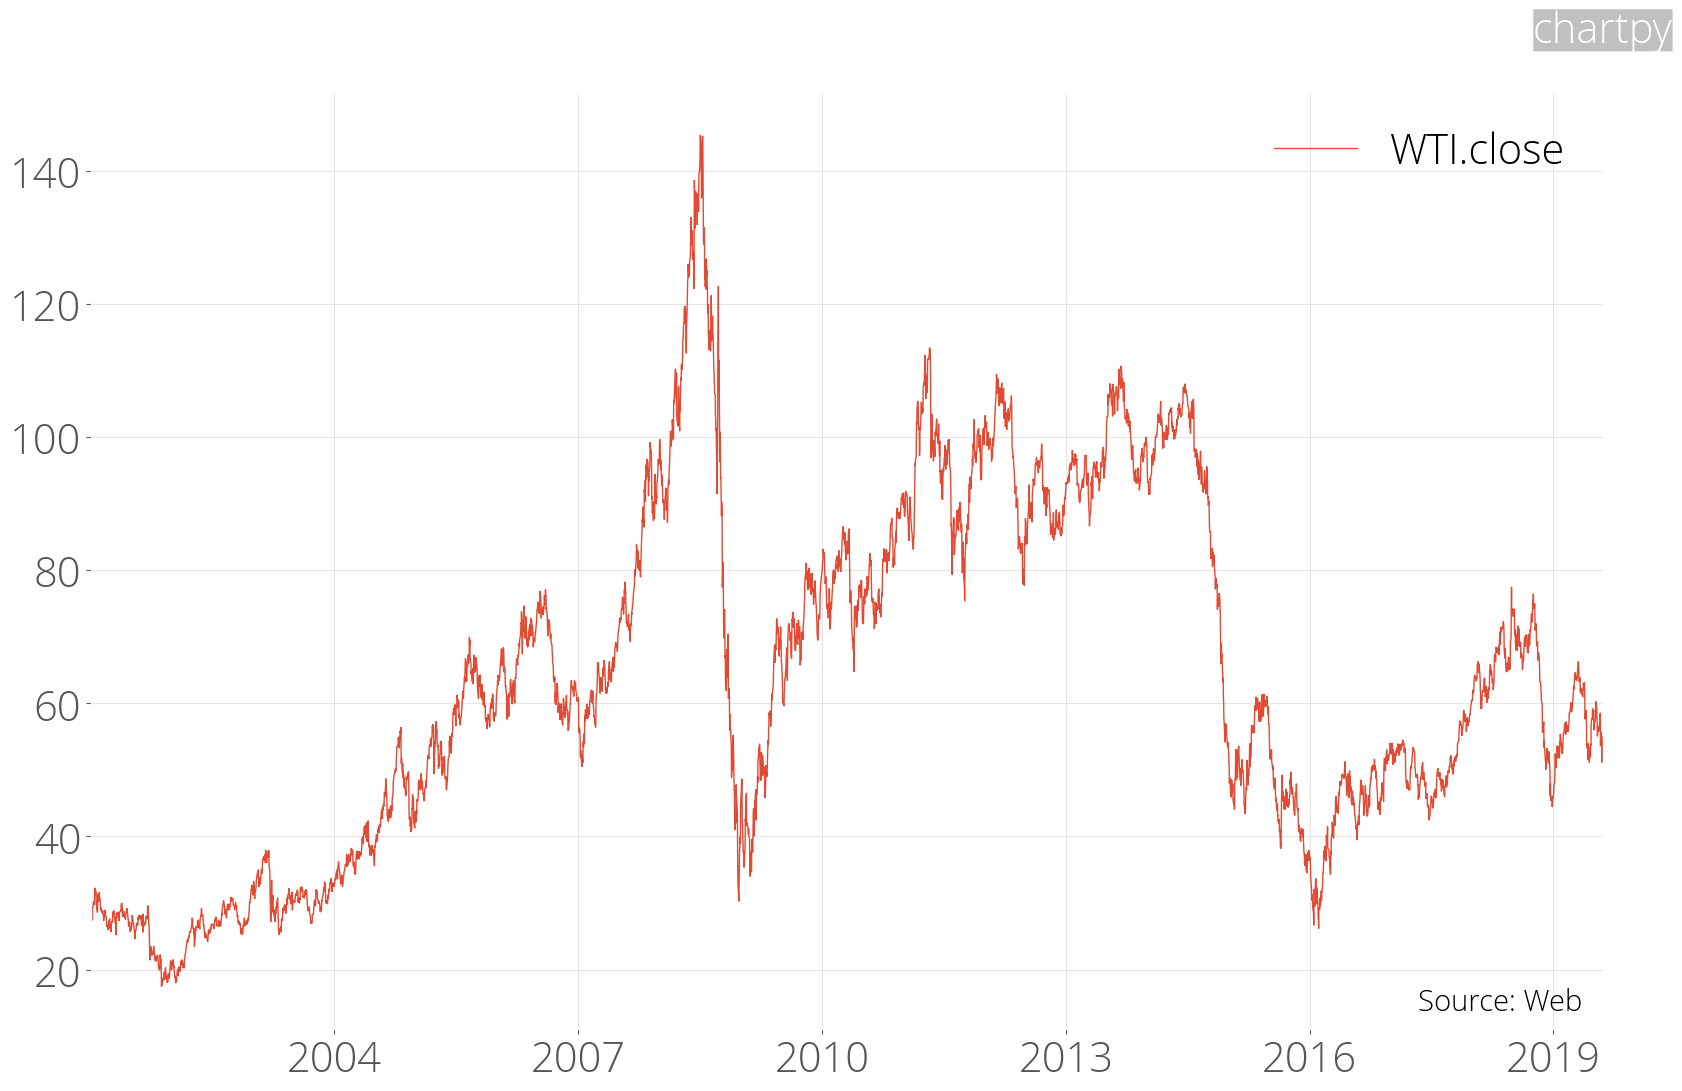

In [3]:
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

md_request = MarketDataRequest(
    start_date='01 Jan 2001', # Start date
    finish_date='12 Aug 2019', # Finish date
    tickers=['WTI'], # What we want the ticker to look like once download
    vendor_tickers=["EIA/PET_RWTC_D"], # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='quandl', # What is the data source?
    quandl_api_key=QUANDL_API_KEY) # Most data sources will require us to specify an API key/password

market = Market(market_data_generator=MarketDataGenerator())

df_wti = market.fetch_market(md_request)

Chart(engine='matplotlib').plot(df_wti)

### ALFRED/FRED - https://alfred.stlouisfed.org and https://fred.stlouisfed.org

FRED is the database of market and economic data compiled from the Federal Reserve of St Louis, one of the regional Fed institutions in the US. It has a massive number of very granular datasets. For example, the US household survey which makes up the release for the US unemployment rate has over 8000 time series on FRED! The US establishment survey which is the source for US change in nonfarm payrolls has over 800 time series on FRED.

ALFRED is the Archival FRED, which enables you to retrieve vintage versions of economic data that were available at specific points in history. In total it has over half a million economic time series available for different vintages! If we think about most economic data, it is often released in several different versions, which are revised. We might initial get the actual release, first revision, before the final release. All of these different releases for the same data point and period may be released several weeks apart. Typically, most economic databases, will only give us the final number. We'll have a quick look at the ALFRED website shortly, to illustrate the idea of vintages in economic time series

For purposes of financial analysis, particularly, backtesting trading strategies, we actually need to have point-in-time data, and can't use data released in the future. This would induce bias in our backtest (usually overstating returns).

FRASER (https://fraser.stlouisfed.org) is another database maintained by the Federal Reserve of St. Louis which is geared towards economic history. It has lots of historical resources going back many decades, like:

* Economic Report of the President
* Budget Reports

Many of the reports on FRASER are in PDF format, so these can be a bit tricky to parse in an automated way.

#### Comparing different revisions of GDP

Below, we'll show how to download various time series in ALFRED/FRED using findatapy. Let's download several vintages of US GDP level, the actual release, the first revision and the revised version. Whilst the GDP level is quite similar, we do see that the initial releases were understating GDP for a long period of time. Here 20000, means 20 trillion USD.

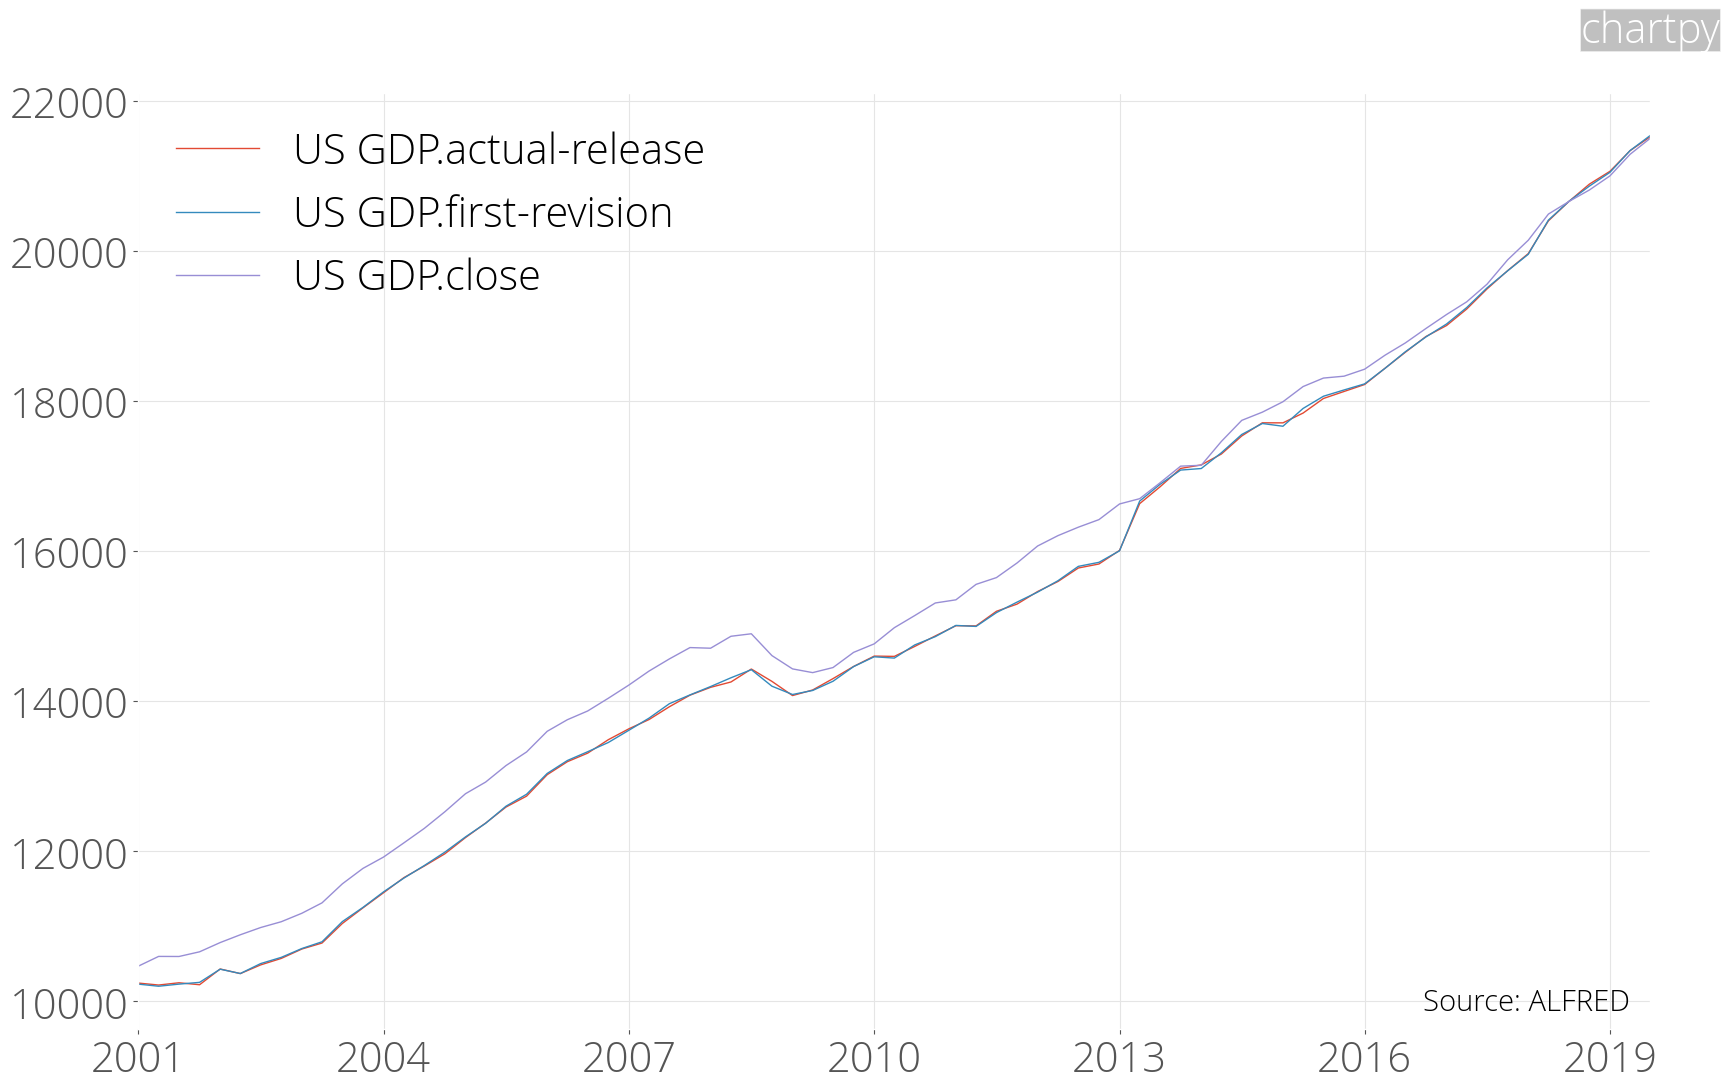

In [4]:
md_request = MarketDataRequest(
    start_date='01 Jan 2001', # Start date
    finish_date='12 Aug 2019', # Finish date
    tickers=['US GDP'], # What we want the ticker to look like once download
    vendor_tickers=["GDP"], # The ticker used by the vendor
    fields=['actual-release', 'first-revision', 'close'], # What fields we want
    data_source='alfred', # What is the data source?
    # vendor_fields=['actual-release', 'first-revision', 'close'],
    fred_api_key=FRED_API_KEY) # Most data sources will require us to specify an API key/password
    
df_fred_gdp = market.fetch_market(md_request)

Chart(engine='matplotlib').plot(df_fred_gdp, style=Style(source='ALFRED'))

#### Downloading market data from FRED

However, it isn't just economic data we can download from ALFRED via findatapy! There is also a lot of market data. Here we plot the difference between 10Y and 2Y yields for US Treasuries and EUR/USD.

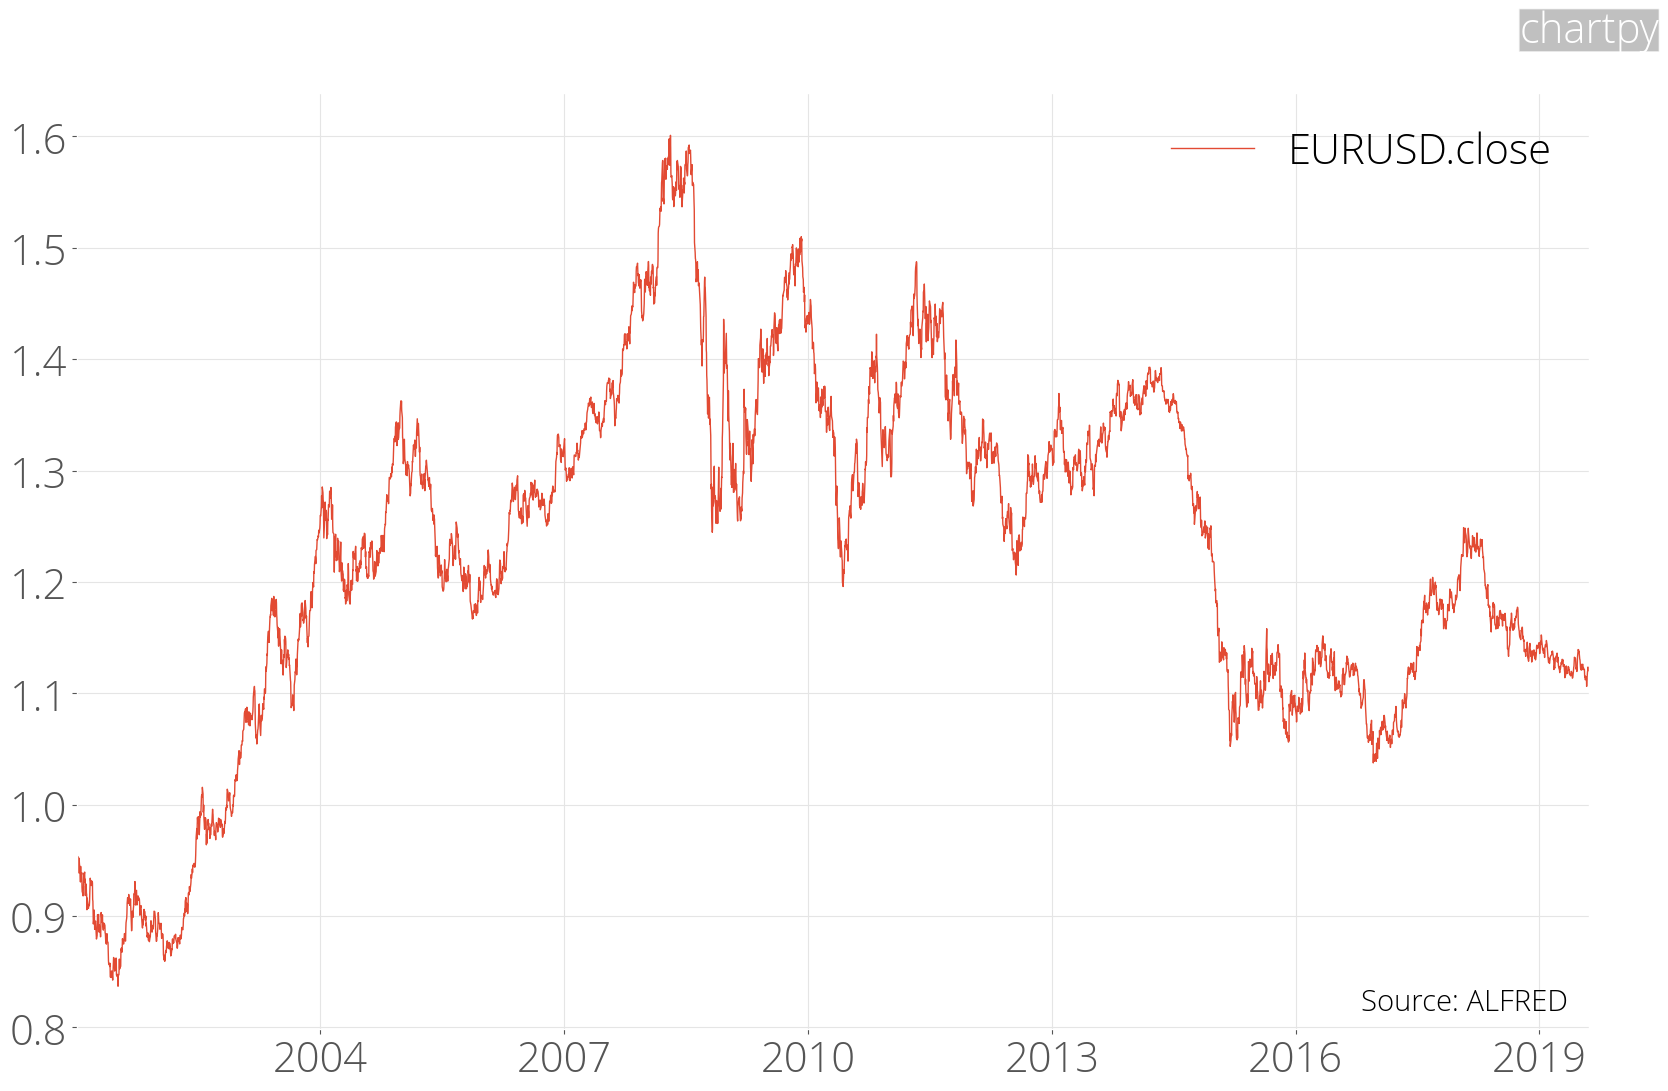

In [5]:
md_request = MarketDataRequest(
    start_date='01 Jan 2001', # Start date
    finish_date='12 Aug 2019', # Finish date
    tickers=['EURUSD'], # What we want the ticker to look like once download
    vendor_tickers=["DEXUSEU"], # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='alfred', # What is the data source?
    fred_api_key=FRED_API_KEY) # Most data sources will require us to specify an API key/password
    
df_fred_eurusd = market.fetch_market(md_request)

Chart(engine='matplotlib').plot(df_fred_eurusd, style=Style(source='ALFRED'))

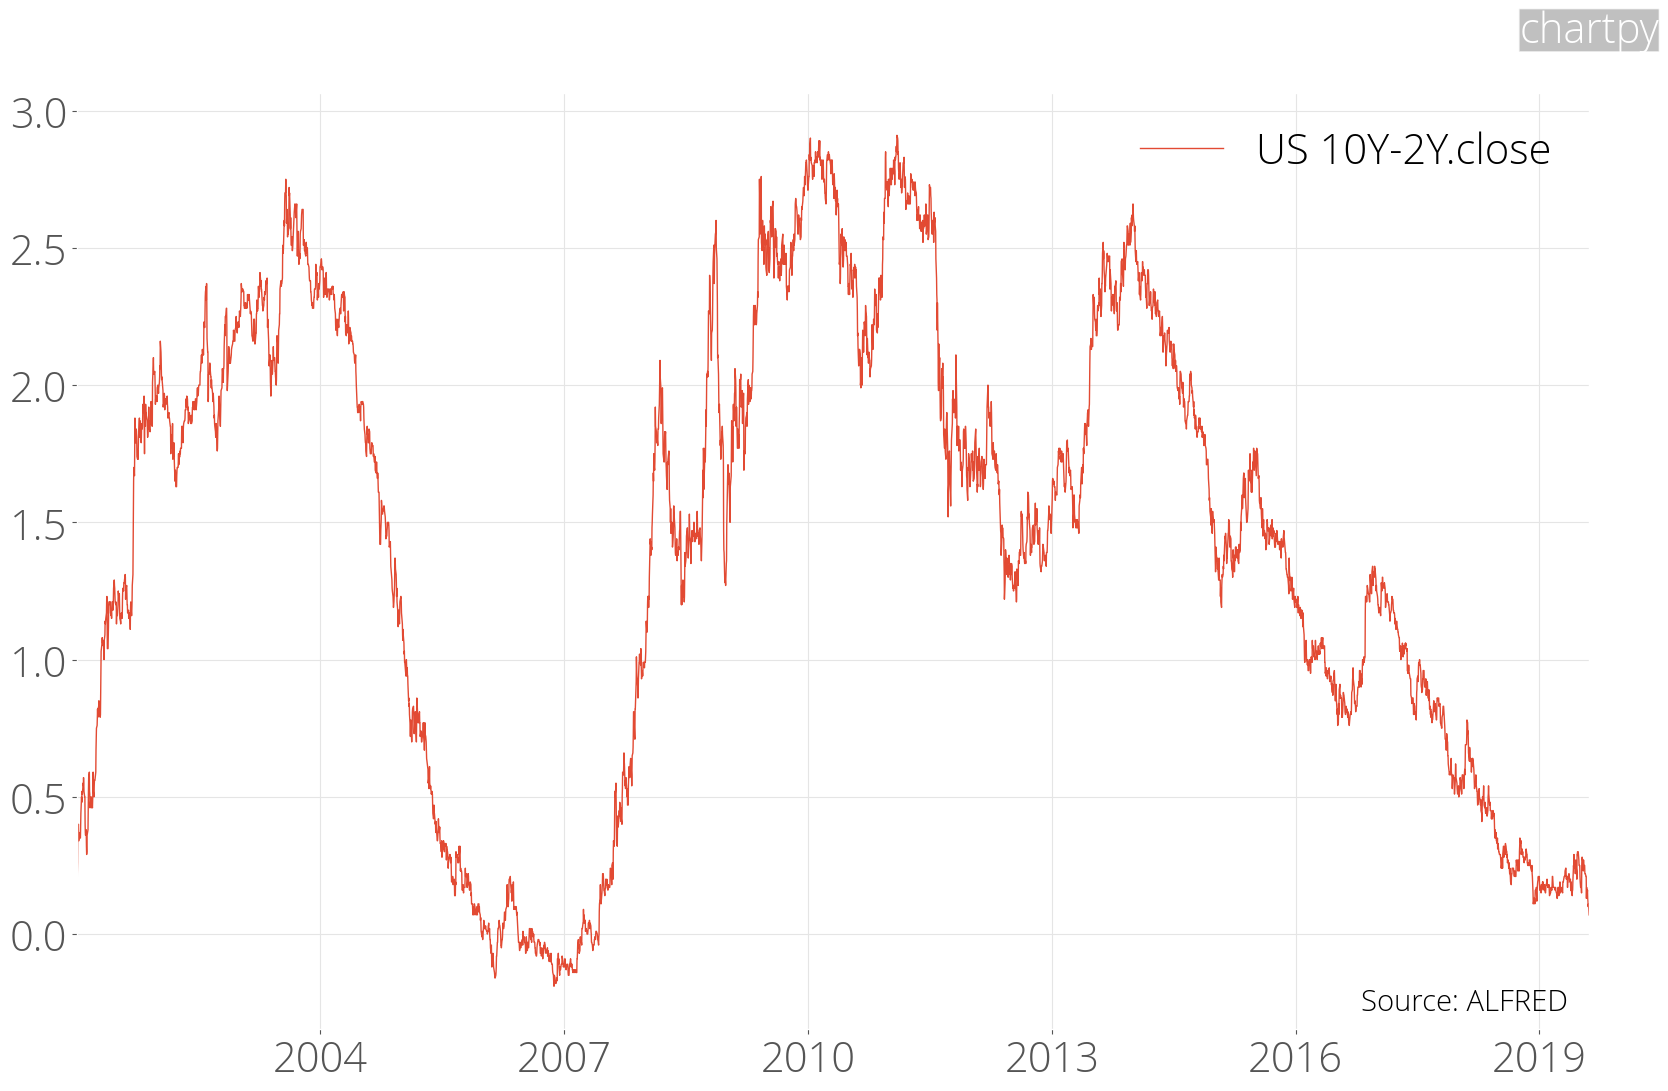

In [6]:
md_request = MarketDataRequest(
    start_date='01 Jan 2001', # Start date
    finish_date='12 Aug 2019', # Finish date
    tickers=['US 10Y-2Y'], # What we want the ticker to look like once download
    vendor_tickers=["T10Y2Y"], # The ticker used by the vendor
    fields=['close'], # What fields we want (usually close, we can also define vendor fields)
    data_source='alfred', # What is the data source?
    fred_api_key=FRED_API_KEY) # Most data sources will require us to specify an API key/password

market = Market(market_data_generator=MarketDataGenerator())
    
df_fred_yield_slope = market.fetch_market(md_request)

Chart(engine='matplotlib').plot(df_fred_yield_slope, style=Style(source='ALFRED'))

### Yahoo - https://uk.finance.yahoo.com

Another popular source of market data is Yahoo Finance. As with Quandl and the other sources we've looked at, we can browse the website to view charts for assets, and also find tickers of interest. For example, to download market data for S&P500, the Yahoo ticker is ^GSPC and we can go to https://uk.finance.yahoo.com/quote/%5EGSPC?p=%5EGSPC to plot this.

#### Downloading stock price data from Yahoo

We can also download time series for S&P500 (broad based index of many stocks) and Apple (single stock) through Python from Yahoo Finance, using findatapy (this also requires the yfinance library). We download both the `close` and `adj close` prices. The adjusted close prices adjust for changes like stock splits for single stocks. You might need to install a newer version of yfinance for this code to work eg. `pip install yfinance==0.1.63`.

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


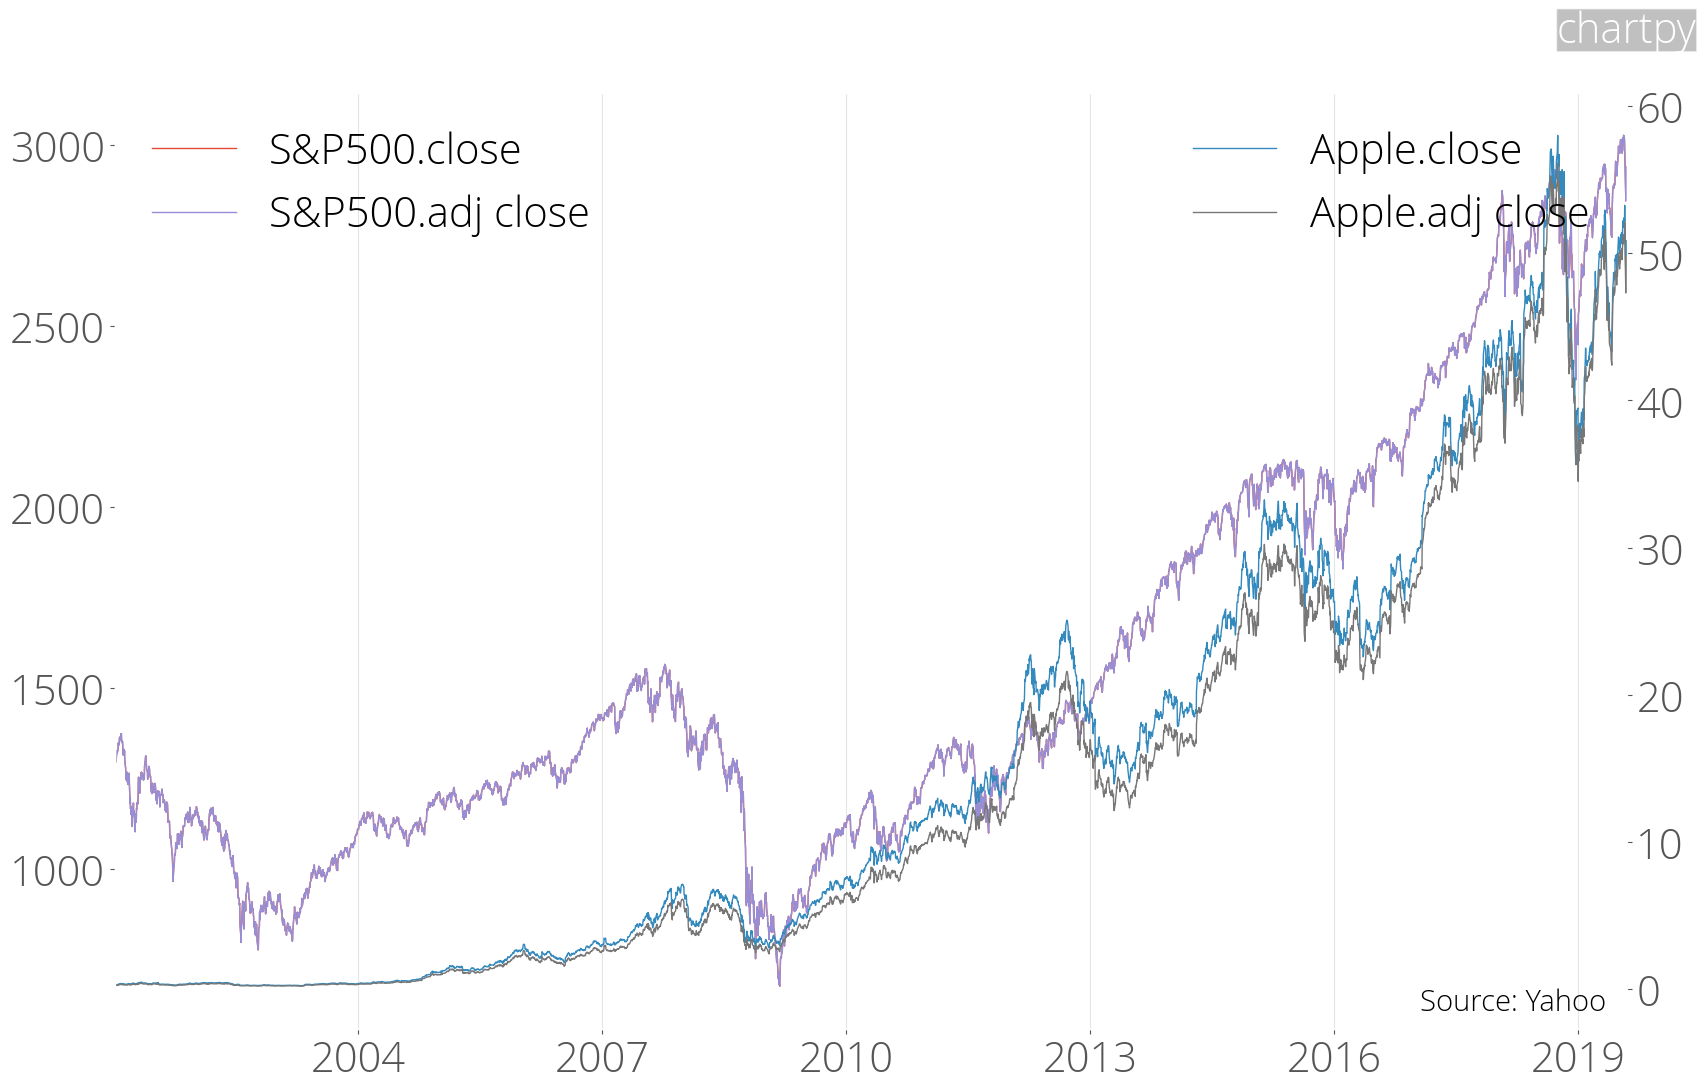

In [3]:
md_request = MarketDataRequest(
    start_date='01 Jan 2001', # Start date
    finish_date='12 Aug 2019', # Finish date
    tickers=['S&P500', 'Apple'], # What we want the ticker to look like once download
    vendor_tickers=["^GSPC", "aapl"], # The ticker used by the vendor
    fields=['close', 'adj close'], # What fields we want (usually close)
    vendor_fields=['close', 'adj close'],
    data_source='yahoo', # What is the data source?
)

market = Market(market_data_generator=MarketDataGenerator())
    
df_yahoo_stocks = market.fetch_market(md_request)

# let's plot using chartpy (with matplotlib as the back-end)
Chart(engine='matplotlib').plot(df_yahoo_stocks, style=Style(
    source='Yahoo', y_axis_2_series=['Apple.close', 'Apple.adj close'], 
    y_axis_showgrid=False, y_axis_2_showgrid=False))

### Bloomberg and BQuant (paid)

Bloomberg is one of the most well known financial data companies. The Bloomberg Terminal can be found across many trading floors. It gives you access to all sorts of information, ranging from news to market data. It is also possible to access the underlying data in Excel via Bloomberg's Excel Addin. For Python users, Bloomberg has an API too. We shall be accessing Bloomberg data using findatapy through `blpapi`. Note, this section of code won't work on your machine unless you have a Bloomberg Terminal (and also have installed Bloomberg's Python API `blpapi`). If you have a Bloomberg subscription, see https://github.com/cuemacro/findatapy/blob/master/BLOOMBERG.md for details of how to install `blpapi`.

Note that, if you have a Bloomberg Terminal, it's also possible to run Jupyter notebooks directly on them through a service called BQuant. We can go to BQNT<GO> to view this.
    
* Advantages 
    * Easy to setup if you already have a Bloomberg Terminal
    * Can easily share your analysis with other Bloomberg Terminal users
* Disadvantages
    * We need to use a lot of proprietary calls to Bloomberg libraries, including using BQL (a Bloomberg based query language).
    * We are locked into using Bloomberg and only Bloomberg Terminal users will be able to view our analysis.
    * Will be very time consuming to rewrite your code to work, if you no longer have access to a Bloomberg Terminal and want to use a different data source
    
You will need to weigh the pros and cons of using BQuant, before getting stuck in.

### Bloomberg Python API (paid)
    
We shall just focus on downloading data locally however through Bloomberg's Python API. The nice thing with using the findatapy library on top of Bloomberg, is we can very easily change our data source, simply by changing a few lines of codes, so we are not locked in using any specific data provider. That will save you a lot of time/money later on and not force you to be locked into a proprietary tool!

Rather than specifiying the specific `start_date`, we can specify keywords like `week` and `year` to download data for recent periods. If we don't provide a finish date, findatapy will assume we mean now. For a small number of tickers (category `fx`), findatapy already stores the Bloomberg tickers (in CSV files in the findatapy/conf folder), so we don't need to remember them. This means we don't need to specify the `vendor_tickers` parameter.

#### Downloading market data from Bloomberg with different frequencies

We can download both daily data and intraday data (usually restricted to the past few months) for EURUSD spot. Note, we have a boolean flag `bbg_installed` which will prevent these from running unless `blpapi` can be found.

In [4]:
# Note our ticker will be internally converted to 
# EURUSD CMPN Curncy, the Bloomberg ticker
md_request = MarketDataRequest(
    start_date='week',
    category='fx',
    tickers=['EURUSD'],
    fields=['close'], # what fields we want (usually close)
    data_source='bloomberg', # what is the data source?
)

market = Market(market_data_generator=MarketDataGenerator())

if bbg_installed:
    df_fx_daily = market.fetch_market(md_request)
    
    md_request.freq = 'intraday'
    df_fx_intraday = market.fetch_market(md_request)

    print(df_fx_daily.tail(5))
    print(df_fx_intraday.tail(5))

            EURUSD.close
Date                    
2022-01-31        1.1235
2022-02-01        1.1272
2022-02-02        1.1305
2022-02-03        1.1440
2022-02-04        1.1457
                           EURUSD.close
Date                                   
2022-02-04 18:22:00+00:00        1.1456
2022-02-04 18:23:00+00:00        1.1455
2022-02-04 18:24:00+00:00        1.1456
2022-02-04 18:25:00+00:00        1.1455
2022-02-04 18:26:00+00:00        1.1454


Note, we use a `;` so Jupyter doesn't print out the output (chartpy will usually return the entire Plotly `Figure` object).

In [5]:
if bbg_installed:
    Chart(engine='plotly').plot(df_fx_intraday.tail(n=300), 
                                style=Style(plotly_plot_mode='offline_jupyter', scale_factor=1.5, 
                                            title='EURUSD Intraday'));

#### Downloading economic event data from Bloomberg

Bloomberg doesn't just have market data. We can also get economic data through the API if we have the appropriate ticker, in this case for US change in nonfarm payrolls. We use a special keyword `events` because we want to download event times.

In [6]:
# now just download the event day
market_data_request = MarketDataRequest(
     start_date="year",
     category="events",
     data_source='bloomberg',            
     tickers=['NFP'],
     fields=['release-date-time-full'],
     vendor_tickers=['NFP TCH Index'], 
     vendor_fields=['ECO_FUTURE_RELEASE_DATE_LIST'])


if bbg_installed:
    df_nfp_times = market.fetch_market(market_data_request)

    print(df_nfp_times)

     NFP.release-date-time-full
Date                           
0           2021-02-05 13:30:00
1           2021-03-05 13:30:00
2           2021-04-02 12:30:00
3           2021-05-07 12:30:00
4           2021-06-04 12:30:00
5           2021-07-02 12:30:00
6           2021-08-06 12:30:00
7           2021-09-03 12:30:00
8           2021-10-08 12:30:00
9           2021-11-05 12:30:00
10          2021-12-03 13:30:00
11          2022-01-07 13:30:00
12          2022-02-04 13:30:00
13          2022-03-04 13:30:00
14          2022-04-01 12:30:00
15          2022-05-06 12:30:00
16          2022-06-03 12:30:00
17          2022-07-08 12:30:00
18          2022-08-05 12:30:00
19          2022-09-02 12:30:00
20          2022-10-07 12:30:00
21          2022-11-04 12:30:00
22          2022-12-02 13:30:00


Just like EURUSD for the `fx` category, nonfarm payrolls are one of the tickers that we have predefined in findatapy. Below, we download nonfarm payrolls again. This time we are downloading additonal fields, including:

* `actual-release` - the actual/first release
* `survey-median` - survey of economists by Bloomberg before the event (consensus/market expectations)
* `survey-high` - the high in the economist survey
* `survey-low` - the low in the economist survey
* `number-observations` - how many economists were in the survey?

Note, you can always add your own tickers to this list if you want (requires editing files in the conf folder, `time_series_categories_fields.csv`, `time_series_fields_list.csv` and `time_series_tickers_list.csv`. 

In [7]:
market_data_request = MarketDataRequest(
    start_date = "year",
    category = "events",
    data_source = 'bloomberg',
    tickers = ['USD-US Employees on Nonfarm Payrolls Total MoM Net Change SA'],
    fields = ['actual-release', 'survey-median', 'survey-high', 'survey-low'])

df_nfp_meta = None

if bbg_installed:
    df_nfp_meta = market.fetch_market(market_data_request)

Next we can plot the time series, this time using Matplotlib. Note that massive volatility around the data in 2020.

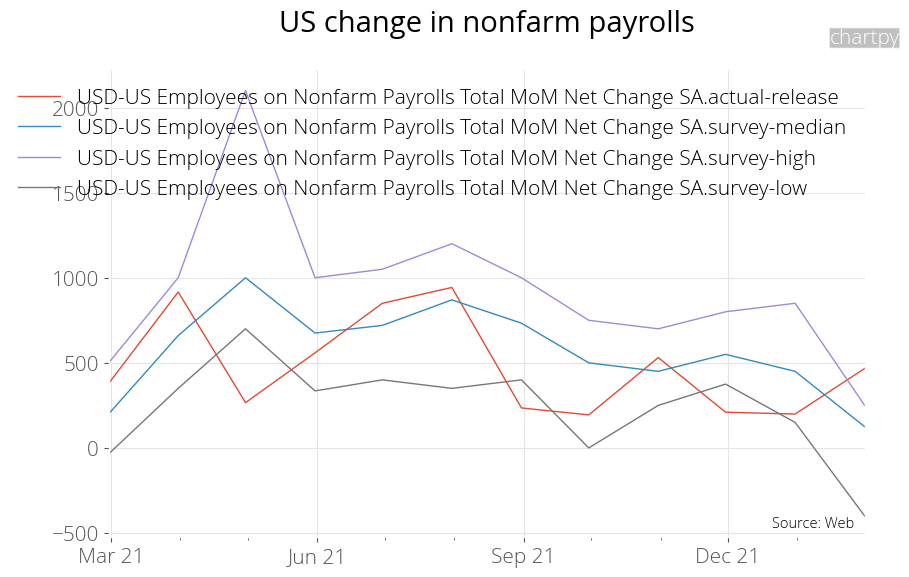

In [8]:
if bbg_installed:
    Chart(engine='matplotlib').plot(df_nfp_meta, style=Style(scale_factor=1.5, 
                                                            title='US change in nonfarm payrolls'));

### Refinitiv Eikon (paid)

Eikon is a financial terminal developed by Refinitiv. If you are running Eikon, you can use findatapy to download market data from Eikon using the following code. Note, this won't execute if you haven't enabled `eikon_installed` boolean variable above. Only change this to `True` if you have Eikon running. You will also need to get an API key from Eikon to type in to replace `EIKON_API_KEY`.

In [13]:
if eikon_installed:
    # Note our ticker will be internally converted to 
    # EUR=, the Eikon ticker
    md_request = MarketDataRequest(
        start_date='week',
        category='fx',
        tickers=['EURUSD'],
        fields=['close'], # what fields we want (usually close)
        data_source='eikon', # what is the data source?
        eikon_api_key=EIKON_API_KEY
    )

    market = Market(market_data_generator=MarketDataGenerator())

    df_fx_daily = market.fetch_market(md_request)

    print(df_fx_daily.tail(5))

### Other sources (paid)

There are many other paid sources of financial data including (these are the most common sources other than Bloomberg, which we have already talked about):

* Refinitiv Data Platform (RDP)
* IHS Markit
* FactSet
* Macrobond
* And many more!

In many cases, they will also have Python APIs to access the data sources.

### DukasCopy (for FX tick data)

DukasCopy is an FX broker for retail clients based in Switzerland. They make markets in most of the major FX crosses. They also offer the ability to download tick data, based on what the prices they quote to clients. You can download the data to use for your own personal purposes.

In [9]:
md_request = MarketDataRequest(
    start_date='03 Jan 2019', # start date
    finish_date='05 Jan 2019', # finish date
    tickers=['EURUSD'], # what we want the ticker to look like once download
    category='fx',
    freq='tick',
    fields=['bid', 'ask'], # what fields we want? bid/ask are available from DukasCopy
    data_source='dukascopy', # what is the data source?
)
    
df_dukascopy_tick = market.fetch_market(md_request);

Let's plot the tick data! We have only plotted the first 1000 points, so it doesn't take too long to plot.

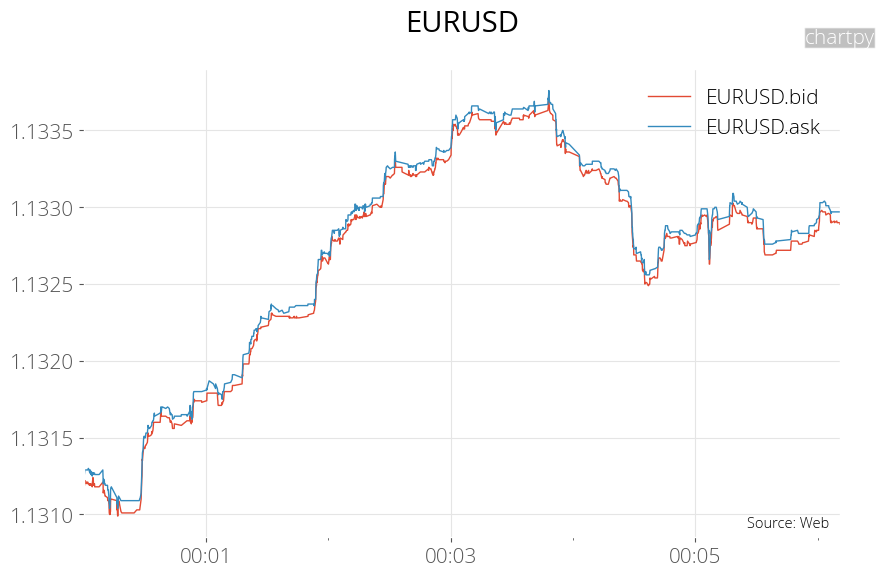

In [10]:
Chart(engine='matplotlib').plot(df_dukascopy_tick.head(n=1000), 
                            style=Style(scale_factor=1.5, title='EURUSD'));

## Market drivers

Before we create a trading strategy, we should try to understand what types of factors impact price action. Once we can get an idea of what factors to use, we can then model them in a trading strategy. This will vary between various asset classes. For example, the drivers for single stocks is likely to be a mix of micro and macro factors. By contrast the drivers for macro assets, such as currencies and sovereign bonds are likely to be driven by macro factors. We shall focus on the FX market here.

### Brief introduction to FX market

The FX market is split into the G10, EM (emerging markets) and also frontier markets. We shall focus on G10 and EM here. Over the years the boundaries between the two have become more blurred. I've written the usual market nickname for each currency (not always the official name). For full details about volumes traded, it's worth looking at the BIS Triennial Survey for FX at https://www.bis.org/statistics/rpfx19.htm. The BIS works on behalf of central banks globally.

* G10
    * EUR - Euro 
    * GBP - Sterling 
    * AUD - Aussie
    * NZD - Kiwi
    * USD - Dollar
    * CAD - Cad
    * CHF - Swiss
    * NOK - Nokkie
    * SEK - Stockie
    * JPY - Yen
    * Generally G10 are quoted against USD (other than Scandis which tend to be traded primarily against EUR)
    * We also have many popular cross rates like:
        * EUR/JPY
        * EUR/GBP
        * AUD/NZD etc.
    * Why have I written them in this order?
    
* EM
    * Latam
        * BRL* - Brazil
        * MXN - Mex
        * CLP* - Chile
        * COP* - Cop
    * EEMEA
        * TRY - Turkey
        * ZAR - Rand
        * RUB - Rouble
        * ILS - Shekel
        * PLN - Poland
        * HUF - Hungary
        * CZK - Czech
        * PLN, HUF and CZK tend to be quoted against EUR primarily
        * Middle East currencies (SAR, QAR, KWD and AED)
    * Asia
        * CNY*/CNH - China
        * KRW* - Korea
        * TWD* - Taiwan
        * INR* - India
        * IDR* - Indonesia
        * SGD - Sing
    * Why have I used an asterisk? Hint: something do with capital controls...

### Long and short of it!

* If we are going short EUR/USD as a financial/speculative transaction this essentially is equivalent to doing this
    * Borrow EUR and selling it
    * Buying USD and investing in it
* Hence, our total returns are made up of
    * Spot returns (the move in the exchange rate)
    * Carry returns (the difference between USD and EUR interest rates)
* In practice, if we are trading FX spot, our position is "rolled" every day
* Every day, when it is rolled we collect (or pay) carry
* Conversely, if we went long EUR/USD, we'd be long EUR and short USD
* Can think of this as similar to being long Apple/USD (although no one says that!)
* When there is a big interest rate differential, there can be a substantial difference between total returns (spot + carry returns) vs. spot returns

#### Carry vs. spot returns

In the below example we plot the index of total returns for being long TRY/JPY versus the spot index for being long TRY/JPY. The first step is to download daily data from Bloomberg (note: needs paid subscription) for TRY/JPY since 2005. Bloomberg calculate total return indices, which makes it easier! We can change the currency pairs to see how it changes the result!

In [16]:
currency_pair = 'TRYJPY'

md_request = MarketDataRequest(
    start_date='01 Jan 2005',
    tickers=['Total returns (carry + spot)', 'Spot returns'],
    vendor_tickers=[currency_pair + 'CR Curncy', currency_pair + ' Curncy'],
    fields=['close'], # what fields we want (usually close)
    data_source='bloomberg', # what is the data source?
)

if bbg_installed:
    market = Market(market_data_generator=MarketDataGenerator())
    
    df_try_daily = market.fetch_market(md_request)
    df_try_daily = df_try_daily.fillna(method='ffill')

The next step is to calculate daily returns. We need reindex each time series from 100, so they are comparable. We use pandas cumprod function in the process. Lastly, we plot using chartpy (via matplotlib). We see the massive difference carry can make in the case of TRY/JPY, because the interest rate differential is huge between TRY and JPY.

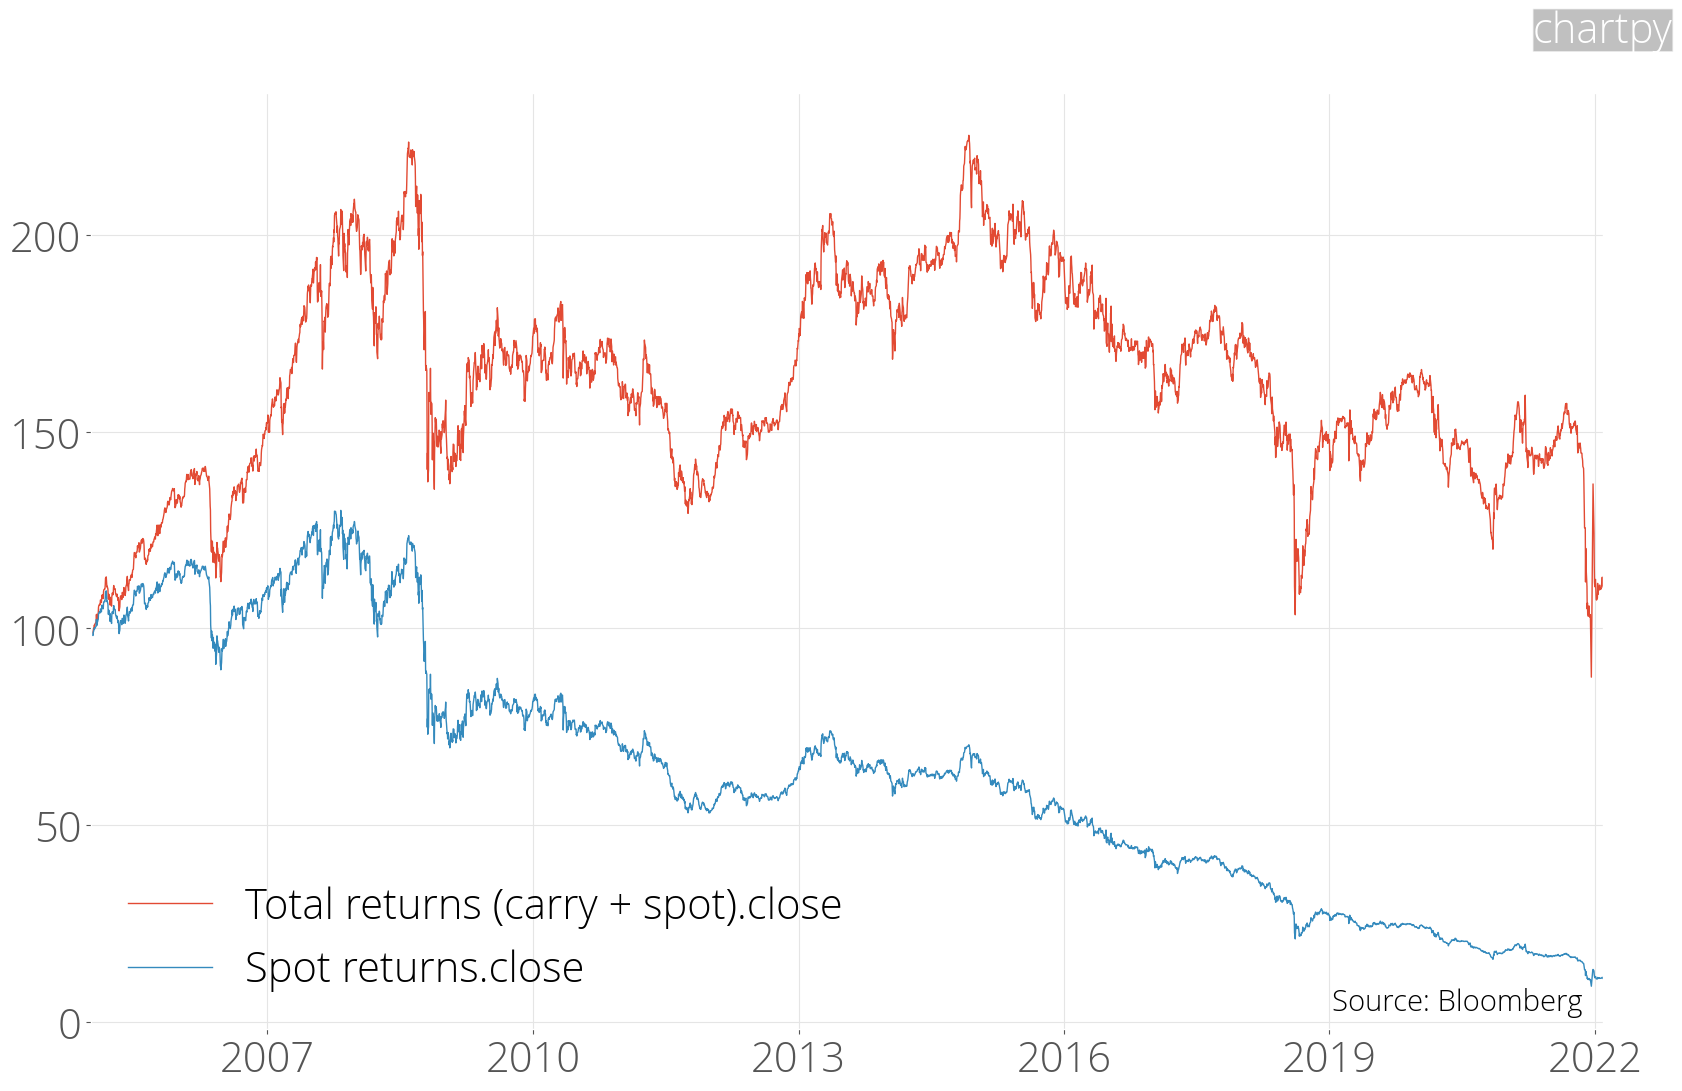

In [17]:
if bbg_installed:

    df_try_daily_returns = df_try_daily / df_try_daily.shift(1) - 1
    df_try_index = 100.0 * (1.0 + df_try_daily_returns).cumprod()
    Chart(engine='matplotlib').plot(df_try_index, style=Style(source='Bloomberg'))

### What are the drivers for FX markets?

We summarise some of the drivers for FX markets. Note, that this isn't an exhaustive list, but should get us started. In many cases, these factors are also relevant for other asset classes

* Trend 
    * Market participants will tend to jump on price trends, expecting them to continue
    * We'll talk more about trend following strategies later, and we'll also backtest an example in Python
* Carry 
    * Traders will borrow in low yielding currencies such as JPY, and then invest the proceeds in high yielding currencies like TRY, to collect the carry (the differential between the interest rates)
    * The risk is that during period of risk aversion the spot price might move against us, wiping out our carry
* Value
    * Over long periods of time we would expect currencies to mean-revert to "fair value"
    * One popular metric for measuring "fair value" is PPP (purchase power parity)
    * An example of a PPP index, is the Economist's Big Mac Index
    * It can take a very long time for a currency to "realign" to fair value
* Risk sentiment
    * During periods of strong risk sentiment, investors will be more inclined to buy "riskier" assets, such as equities, high yield bonds and carry trades
* Positioning and sentiment
    * What are the positions of other market participants in a certain asset
    * If everyone is already short, then the market might be suceptable to squeezes, as market participants try to liquidate their exposure all at once
* Fundamentals
    * The economic picture can impact currencies
    * For developed markets, typically stronger economic growth is accompanied by a rise in bond yields, as the market expects the central bank to hike rates
    * Conversely, weak growth data and inflation data, could result in a dovish central bank outlook
    * Monitor all sorts of economic data (growth, inflation, labor market etc.) and also central bank communications to find clues
* Flows
    * A lot of transactions that go through the FX market are secondary, ie. they are based on other transactions
    * M&A example
        * A US company might buy a UK company (M&A transaction)
        * This means the US company will likely need to sell USD and buy GBP to do the M&A deal
        * This will cause a positive flow into GBP, and negative for USD
    * Portfolio example
        * This can also apply for foreign investors buying all sorts of other assets (bonds, equities, real estate etc)
    * Can also look at FX flows directly, to piggy back on them, although the data is more difficult to find expensive
    * Some times they might seek to hedge this FX risk
* Politics
    * Especially in recent years, politics has been a huge driver for markets
    * Historically, has been mostly an EM issue
    * Increasingly seeing it in developed markets
        * USD and trade with China
        * GBP and Brexit
* News
    * More broadly news is an important driver, which can come from many of the areas already mentioned, like politics, economic news, what central banks are saying, weather/natural disasters (eg. hurricanes, earthquakes etc.)

## Understanding market risk

When it comes to trading financial markets, we need to have an idea of market risk. After all, trading is essentially a matter of managing risk, to create a reward. Different assets will have different levels of risk. This will impact how we weight them in a portfolio.

### Calculating realized volatility

One of the simplest measures for risk, is to look at the volatility of an asset. There are two types of volatility. The first is realized volatility. This is calculated on asset returns on a rolling historical basis. We can calculate it across different tenors. Obviously, the problem with realized volatility (or historical volatility) is that it is backward looking. However, we can (generally) rely on the fact that realised volatility tends to be autocorrelated. Implied volatility is the market's expectations for future realized volatility based on option prices. 

Typically, implied volatility is higher than where realized volatility ends up. This is because there is usually a risk premium. If a trader sells options, essentially, future volatility is unknown, so it's like selling insurance, so they need to be compensated for that. In the next lesson, we shall look at many different models for calculating realized volatility.

As a first step let's download data for crude oil and EUR/USD spot. We fill any NaN values.

In [17]:
import quandl

quandl.ApiConfig.api_key = QUANDL_API_KEY

df_wti_eur = pd.DataFrame(quandl.get(["EIA/PET_RWTC_D",'FRED/DEXUSEU'], 
                        start_date="2000-01-01", end_date="2019-12-31"))
df_wti_eur.columns = ['WTI', 'EURUSD']
df_wti_eur = df_wti_eur.fillna(method='ffill')
df_wti_eur = df_wti_eur.dropna()

Let's print the data to see what the values look like.

In [18]:
print(df_wti_eur.head(5))

              WTI  EURUSD
Date                     
2000-01-04  25.56  1.0309
2000-01-05  24.65  1.0335
2000-01-06  24.79  1.0324
2000-01-07  24.79  1.0294
2000-01-10  24.71  1.0252


The first step to calculating volatility on the underlying assets, is to calculate the daily percentage returns on each assets.

In [19]:
df_wti_eur_rets = df_wti_eur / df_wti_eur.shift(1) - 1.0

As an intermediate step, let's plot the rebased prices of each. Just by looking at it, it's clear that crude oil appears to move more!

<AxesSubplot:xlabel='Date'>

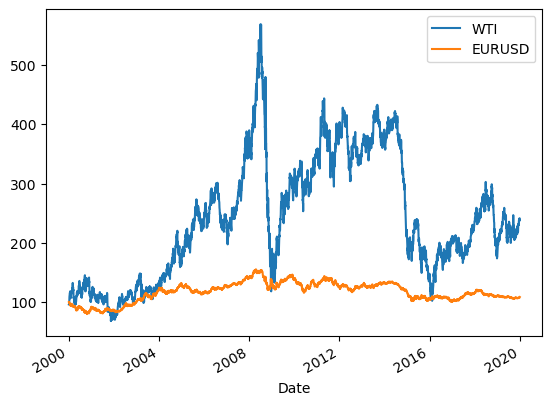

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('default') # changes the matplotlibplot style...

df_wti_eur_price_index = 100 * (1 + df_wti_eur_rets).cumprod()

df_wti_eur_price_index.plot()

Then we need to calculate the rolling volatility (ie. standard deviation). We can use pandas in built functions. We use 20 working days, which is the equivalent of 1 month. We also multiply by the square root of 252, to annualize the daily volatility to annualized volatility. We multiply by 100, to make the percentage easier to read.

In [21]:
import math

df_wti_eur_vol = df_wti_eur_rets.rolling(20, min_periods=1).std() * math.sqrt(252) * 100

Now time to plot it!

<AxesSubplot:xlabel='Date'>

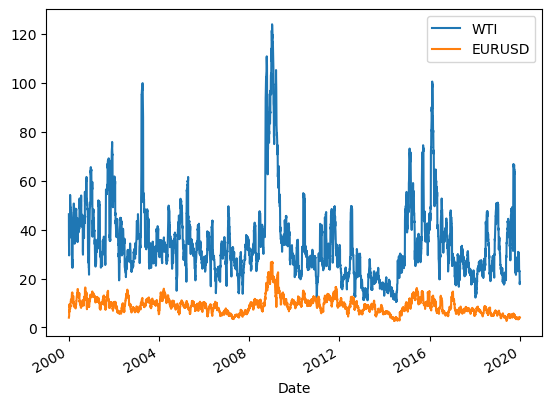

In [22]:
df_wti_eur_vol.plot()

Later, we will use realized (or historical) volatility to help weight our assets monthly in the portfolio by their relative volatility weighting. Is this fair? In other words, will realized volatility over the past month, be a reasonable predictor to realized volatility the next month? One way we can test this is through autocorrelation at different lags. We can see that at short monthly lags, yes, we do get a lot of positive autocorrelation. In other words, if vol is high now, it is likely to be high next month. We repeat the exercise for EURUSD and WTI.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

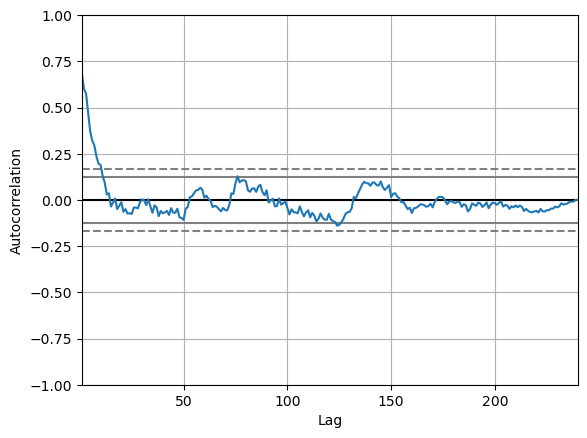

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_wti_eur_vol['EURUSD'].resample('BM').last())

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

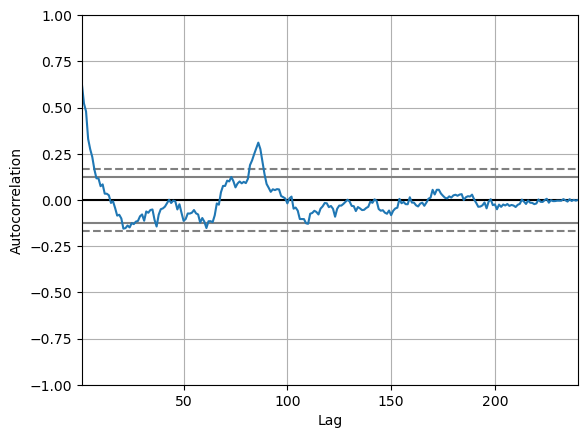

In [24]:
autocorrelation_plot(df_wti_eur_vol['WTI'].resample('BM').last())

We see that the volatility of crude oil is significantly more than EUR/USD. We calculate then plot the ratio of the crude oil realized volatility to EUR/USD realized volatility. On average crude oil is 4 times more volatile than EUR/USD.

4.107004048868903


<AxesSubplot:xlabel='Date'>

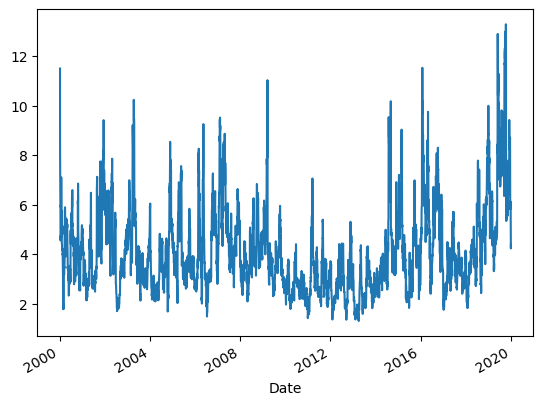

In [25]:
df_wti_eur_vol_ratio = df_wti_eur_vol['WTI'] / df_wti_eur_vol['EURUSD']
df_wti_eur_vol_mean_ratio = df_wti_eur_vol_ratio.mean()

print(df_wti_eur_vol_mean_ratio)
df_wti_eur_vol_ratio.plot()

Let's say we wanted to create a portfolio which had 50 USD worth of crude and 50 USD worth of EUR/USD (ie. a notional 50 USD in each). Our total portfolio is 100 USD in notional. In notional terms it would look like we have an equal amount of risk in each asset. However, crude is 4 time more volatile! Hence, in practice, we are exposed to on average 4 times the risk in our crude oil allocation than we are in EUR/USD!

### Volatility weighting portfolio allocations

So how can we allievate this issue that we don't have "equal" amounts of risk, despite having the same amount of notionals? One simple way to fix this is by using volatility targeting. We can create a volatility target for each asset. We adjust the leverage on each asset depending on its volatility. 

$$\text{asset leverage} = \frac{\text{volatility target}}{\text{asset volatility}}$$

Below we calculate the leverage for each asset using a 10% volatility target. We assume the leverage changes every day. In practice, we would likely have rebalancing at a lower frequency like monthly, otherwise, we would end up incurring high transaction costs from the continually rebalancing.

<AxesSubplot:xlabel='Date'>

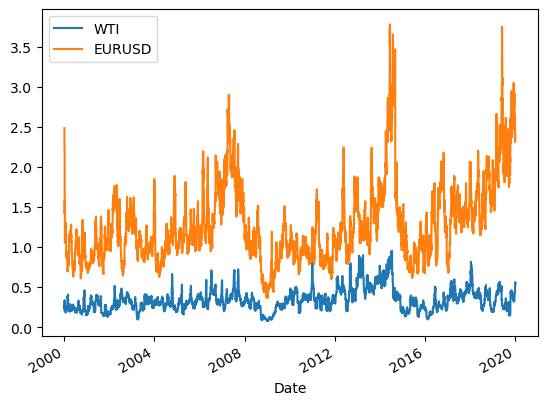

In [26]:
df_asset_leverage_daily = 10.0 / df_wti_eur_vol

df_asset_leverage_daily.plot()

Hence, to make it more realistic, let's resample to monthly data, and then back down to business days. Hence, our leverage factor will be flat over the month now.

<AxesSubplot:xlabel='Date'>

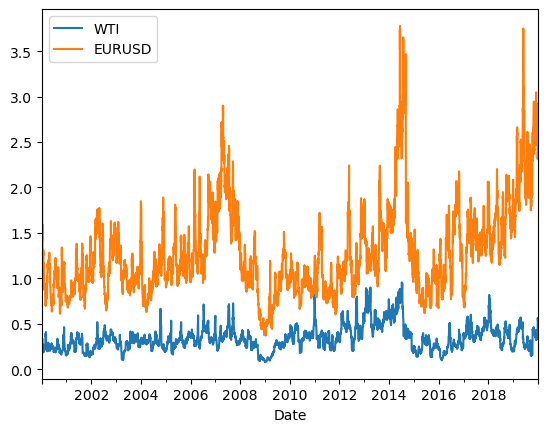

In [27]:
df_asset_leverage = df_asset_leverage_daily.resample('BM').last()
df_asset_leverage = df_asset_leverage_daily.resample('B').last().fillna(method='ffill')

df_asset_leverage.plot()

Let's calculate the portfolio returns assuming equal notional and also assuming an asset leverage adjusted notional. We'll calculate an index rebased at 100.

In [28]:
df_equal_notional_portfolio_rets = df_wti_eur_rets.mean(axis=1)
df_asset_vol_weighted_rets = (df_asset_leverage * df_wti_eur_rets).mean(axis=1)

df_equal_notional_portfolio = 100 * (1 + df_equal_notional_portfolio_rets).cumprod()
df_asset_vol_weighted_portfolio = 100 * (1 + df_asset_vol_weighted_rets).cumprod()

As a final step, let's combine the portfolio indices into one dataframe (ie. one based on equal notional and the other based on an asset weighted vol portfolio)

In [32]:
import pandas as pd

df_equal_notional_portfolio_index = pd.DataFrame(df_equal_notional_portfolio)
df_equal_notional_portfolio_index.columns = ['Equal notional']

df_asset_vol_weighted_portfolio_index = pd.DataFrame(df_asset_vol_weighted_portfolio)
df_asset_vol_weighted_portfolio_index.columns = ['Asset vol adjusted notional']

df_index = df_equal_notional_portfolio_index.join(df_asset_vol_weighted_portfolio_index)

Let's calculate the annualized volatility of each portfolio.

In [33]:
df_index_rets = df_index / df_index.shift(1) - 1

ann_vol = df_index_rets.std(axis=0) * math.sqrt(252)

print(ann_vol * 100.0)

Equal notional                 20.430070
Asset vol adjusted notional     7.625407
dtype: float64


We see that are finally volatility of our portfolio is around 8%. This isn't exactly our volatility target 10%. However, this is of course, because we can't forecast volatility exactly. Finally we can plot the final portfolios. We see that the equal notional portfolio is most volatile!

<AxesSubplot:xlabel='Date'>

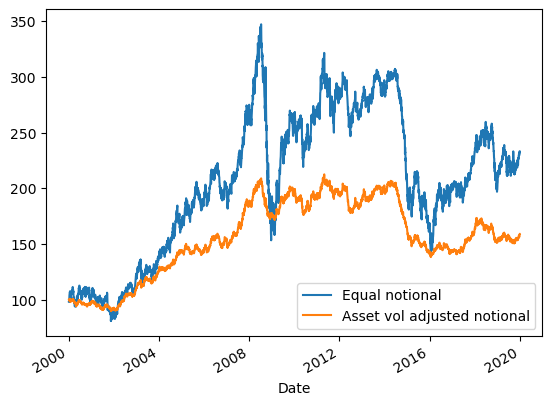

In [34]:
df_index.plot()

As well as calculating the leverage at the individual asset level, we can also do the same thing at portfolio level. In other words, we'd calculate the volatility of portfolio returns and use that to calculate a portfolio leverage.

$$\text{portfolio leverage} = \frac{\text{volatility target}}{\text{portfolio volatility}}$$

Hence, our final leverage for each signal would be

$$\text{final leverage} = \text{asset leverage} \times \text{portfolio leverage}$$

Later, we'll use both asset (signal) based volatility targeting and portfolio based volatility targeting on a trend following strategy.

### Other methods for constructing portfolios

Using equal notionals or having a volatility based weights are not the only way for allocating in a portfolio. Markovitz portfolio construction (mean-variance) involves estimating the portfolio weights, based not only on the volatility of the underlying but also the correlations between them. Volatility based targeting can be viewed as a special case, except assuming the correlations are zero. We also have constraints in Markovitz relating the returns.

## Creating a trading strategy

### How to design a trading strategy

Put very simply a trading strategy involves a series of trades, where we are trying to optimise our profits. The difficulty is that the only dataset we have is a historical one. However, to monetize a trading we have to trade it in a live environment. Hence, having amazing performance on our historical dataset, does not necessarily mean it'll be profitable live.

#### Having a hypothesis

Before we even sit at our computer, we need to come up with a trading hypothesis to test, and in particular having a strong rationale for it. This idea might be informed by our own experience of markets, reading books or hearing what other people are doing in the markets. It isn't always the case that this hypothesis will "work". In effect, we are trying to prune our search space of trading ideas, to one which is plausible and (hopefully) removing a large number of spurious trading strategies, which happen to fit the data. By having a well thought out hypothesis, the rationale is that it is more likely to be robust out-of-sample. Our earlier section where we explained market drivers for FX should be helpful for this. If you're looking at a different market you'll probably need another set of drivers.

#### In-sample and out-of-sample

In practice, we should split up our historical data, into an in-sample period. Here we can play with the data, change the parameters etc. The rest of the data (say 20% of the most recent data), we designate as our out-of-sample period, which our model does not see earlier in the process. We should only look at this data right at the end of the project for testing. If the data has been heavily overfitted then it will likely show up in very poor performance during the out-of-sample period.

#### A good backtest.. doesn't always mean it'll work in the future

It might be the case that the backtest shows that our trading strategy is heavily loss making historically. This doesn't always mean it won't perform well in the future. However, for it to perform, we need to have a strong view that markets will behave very differently from the past. It can also be the case that other factors in the backtest make our strategy loss making such as transaction costs. It is not uncommon for transaction costs to be inaccurately used in a backtest, only to find that in a life environment the transaction costs make a strategy loss making. In practice, many strategies we might backtest are unlikely to be attractive enough to trade live. We also might end up backtesting a trading strategy whose correlation is high to existing strategies we are running. Hence, it is not worth adding to our existing portfolio.

#### Paper trading

Once we are happy with the performance during the in-sample and out-of-sample periods and appears to add value to our existing portfolio, we can then do paper trading. This involves trading it in a live environment, but not actually executing the trades, and instead trading with "paper" money. This paper trading phase, can be seen as a further out-of-sample test, and help to iron out any problems. If the paper trading step is successful, investors will then start to trade with real capital. Typically, this starts out with small amounts of cash, and then this is increased over time, if the strategy performs well.

### Backtesting a trading strategy - Part 1

#### How to understand the historical profitability of a strategy

A backtest involves simulating how a trading strategy would have performed historically. We can use several metrics to understand profitability of a strategy during backtesting.

* Annualized returns - This is the most obvious one! What were the percentage returns (of the notional) over the year on average
* Annualized volatility - This is a measure of risk of the returns of the strategy, also known as standard deviation
* Information ratio - This is the risk adjusted returns, essentially the returns against a benchmark divided by its volatility. The Sharpe ratio is very similar, except the benchmark is risk free returns. Typically for FX markets, given there is no widely acknowledged benchmark (or market beta), we usually just calculate 

$$\frac{\text{annualized returns}}{\text{volatility of returns}}$$

* In FX, the closest thing we can get to a market beta, is to create generic versions of popular strategies like trend, value and carry, and use that as a proxy for FX market beta. My paper discusses market beta within FX at https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2439854

#### What is a trend following strategy?

Very simply a trend following strategy, seeks to buy an asset when the price goes up. Conversely, it sells an asset when the price down. It is the opposite of a mean-reverting strategy (ie. buy low and sell high). Typically, most trend following funds, will be trading longer term trends in markets. There are many different explanations for why trend following should work. One rationale, is related to investor behaviour, who might be afraid of losing out by not jumping on prevailing trends.

Hence, it becomes a self fulfiling prophecy. As investors start to profit take the trend will diminish. Trend following funds will often be known as CTA, commodity trading advisors, because historically they used to trade commodities. In practice, today trend following funds will actively trade many different markets, ranging from FX, fixed income, equities and commodities. In recent years trend following strategies have come under pressure. Hence, as a result many of the well known trend following funds have reduced their exposure to trend. Winton, one the most well known UK quant funds, who have historically been trend followers, cut their trend strategy exposure to 50%.

#### When are markets trending or ranging?

It can be difficult to know when markets are trending (and hence, you should do trend following) or when they are ranging (and hence use a more range bound strategy). However, one approach you might be able to try is to calculate the volatility of the returns of the price. Typically, trends tend to be building when volatility rises, and tend to diminish when they fall.

#### What is a technical indicator?

A technical will take in price data (or sometimes other sorts of data which are relevant to the market) and then transform it in some way to give us an insight about price action). One of the simplest, which we shall focus on is the simple moving average. This is simply the rolling average of the price time series. The most common trading signal is based on the price crossover with the moving average. Typically, when the price is above the moving average, we buy. When it is below the moving average we are short. We shall can illustrate some of these on a Bloomberg Terminal (or of course you can calculate with Python and then plot!)

The finmarketpy library implements many popular technical indicators including:

* SMA - simple moving averages
* EMA - exponentional moving averages
* Bollinger Bands - Bollinger bands
* RSI - relative strength indicator
* ROC - rate of change
* SMA2 - double moving averages

You can see the code for constructing these technical indicators as well as typical trading signals associated with them at https://github.com/cuemacro/finmarketpy/blob/master/finmarketpy/economics/techindicator.py

Also check out a Python wrapper for the popular TA-Lib library at https://github.com/mrjbq7/ta-lib. It is trickier to install, but has many more technical indicators which you can use.

#### Steps of doing a backtest for trend following

Below we give the rough steps we need to complete for backtesting a trend following trading strategy (it can be much more complicated than this in practice, through the addition of new steps):

* Download market data
* Calculate technical indicator on market data
* Calculate trading signal based on technical indicator (+1,-1)
* Calculate the returns on market data
* Calculate the strategy returns by multiplying the previous periods signal with the returns
* Calculate return statistics on the strategy returns (eg. annualised returns, information ratio etc.)
* Calculate the cumulative strategy returns index
* Plot results

#### Coding up a backtest with Pandas

This type of approach for backtesting is probably the simplest. It is also good from a computational perspective, because a lot of the operations can be vectorized (for example, multiplying the signal by the returns, taking away transaction costs etc.)

A more complicated way is doing an event driven backtest. In this case rather than mulitplying the returns by the signal, we instead use a look. We simulate new market data coming. Every time this occurs we update our signal and mark to market. The nice thing about an event driven approach is that we can feed it historical data, to do a backtest and we can also feed it live data when we're actually trading. Hence, we can use the same code to do a backtest and to trade live with an event driven approach. Quantopian's `zipline` Python library is an event driven backtesting library.

Obviously to trade live, we would also need to actually execute trades in the market. Hence, for an event driven approach to be used for live trading, we would additional code for executing trades in the market. Clearly, backtested trades cannot be executed in a live environment (we can't execute with counterparties with prices in the past..!)

We shall do a a very simple backtest, using Pandas and NumPy, showing all the steps in the process. This is obviously a very simple example, and we might want to use a more complicated approach to backtesting in practice. We flag the point that we are just using FX spot returns to represent the returns of the asset. In practice, the total returns of holding the asset also have a component of carry associated with them, which we are ignoring here.

As a first step, we download the historical time series for EUR/USD as a Pandas `DataFrame`, which is the asset we want to trade in our backtest. We'll just use Quandl's Python library here, for simplicity. Later, we'll try using findatapy. If you don't have a Quandl API key, you can just change use_quandl to False, in which case it'll download the EURUSD data from CSV I've put up on GitHub.

NOTE: for simplicity we are using spot data here, and we are not calculating total returns which would require us to have interest rate data too. If you have Bloomberg, we already have total returns data for FX, as we saw earlier. For trend following strategies this won't make a massive difference to returns. However, for carry strategies, just using spot data to calculate returns would give us very inaccurate backtested results (recall our TRY/JPY example!)

In [11]:
import quandl

# We should have set the Quandl API key earlier! Remember to change this to your key
quandl.ApiConfig.api_key = QUANDL_API_KEY

# Use Quandl or get from GitHub
use_quandl = True
# use_quandl = False # Uncomment if you don't have Quandl API key

if use_quandl:
    # Read from Quandl data service (may take time to download)
    fx_df = pd.DataFrame(quandl.get('FRED/DEXUSEU', start_date="1999-01-01"))
    fx_df.columns = ['EURUSD.close']

    fx_df.to_csv(raw_data_path + 'EURUSD.csv') # Save to disk in case want to read back later
else:
    # Read from GitHub
    fx_df = pd.read_csv(
        "https://raw.githubusercontent.com/cuemacro/teaching/" + \
        "master/pythoncourse/data/EURUSD.csv",
        index_col=0)
    
    fx_df.index = pd.to_datetime(fx_df.index)
    
print(fx_df.head(5))

            EURUSD.close
Date                    
1999-01-04        1.1812
1999-01-05        1.1760
1999-01-06        1.1636
1999-01-07        1.1672
1999-01-08        1.1554


Then we calculate the 200 day simple moving average. Our signal is composed of -1 or +1. When the spot price is above the simple moving average, we are long (ie. +1). Otherwise, we are short (ie. -1).

In [12]:
tc = 2.0 / (2.0 * 100.0 * 100.0) # 2 bp bid/ask transaction costs

# Calculate the simple moving average and then trading signal
# Note: for the initial part of the sample the trading signal
# will be NaN and undefined
fx_sma_df = fx_df.rolling(200, min_periods=1).mean()
fx_signal = np.where(fx_df > fx_sma_df, 1.0, -1.0)   
fx_signal_df = pd.DataFrame(index=fx_df.index, data=fx_signal, columns=fx_df.columns)

Next, we need to calculate the daily percentage returns for being long the asset (EUR/USD). Whilst we use simple returns, we could also try using log returns.

In [13]:
fx_ret_df = fx_df / fx_df.shift(1) - 1.0

Next step is to calculate the strategy returns, which are the previous day's signal multiplied by the percentage return from the previous day till today. It is very easy to mess up this lag so please double check (typically, the results will look a lot better if you don't lag them properly). In general, when results look too good, eg. you get a totally straight line for your cumulative index of strategy returns, it is *usually* because of a mistake, rather than an amazing signal.

Typically, this happens when you mistakenly use future data in your signal (ie. have lookahead bias).

In [14]:
# The strategy returns are simply the previous days signal multiplied by returns between 
# that day and the next
fx_strat_ret_df = fx_signal_df.shift(1) * fx_ret_df \
    - abs(fx_signal_df - fx_signal_df.shift(1)) * tc

We can calculate some of the return statistics, in this case, annualized returns, annualized volatility and the information ratio.

In [37]:
import math

ann_factor = 252

ann_ret = fx_strat_ret_df.mean(axis=0) * ann_factor
ann_vol = fx_strat_ret_df.std(axis=0) * math.sqrt(ann_factor)
info_ratio = ann_ret / ann_vol

print("Ret = " + str(round(ann_ret[0] * 100,1)) + "%")
print("Vol = " + str(round(ann_vol[0] * 100,1)) + "%")
print("IR = " + str(round(ann_ret[0]/ann_vol[0],1)))

Ret = 2.9%
Vol = 9.4%
IR = 0.3


The last step is to compute a cumulative index of returns. We can calculate returns statistics directly from `fx_strat_ret_df`. However, we can also recalculate strategy returns from `fx_cum_strat_ret`, which could end up being slightly different, because of the mulitplicative effect of reinvesting returns.

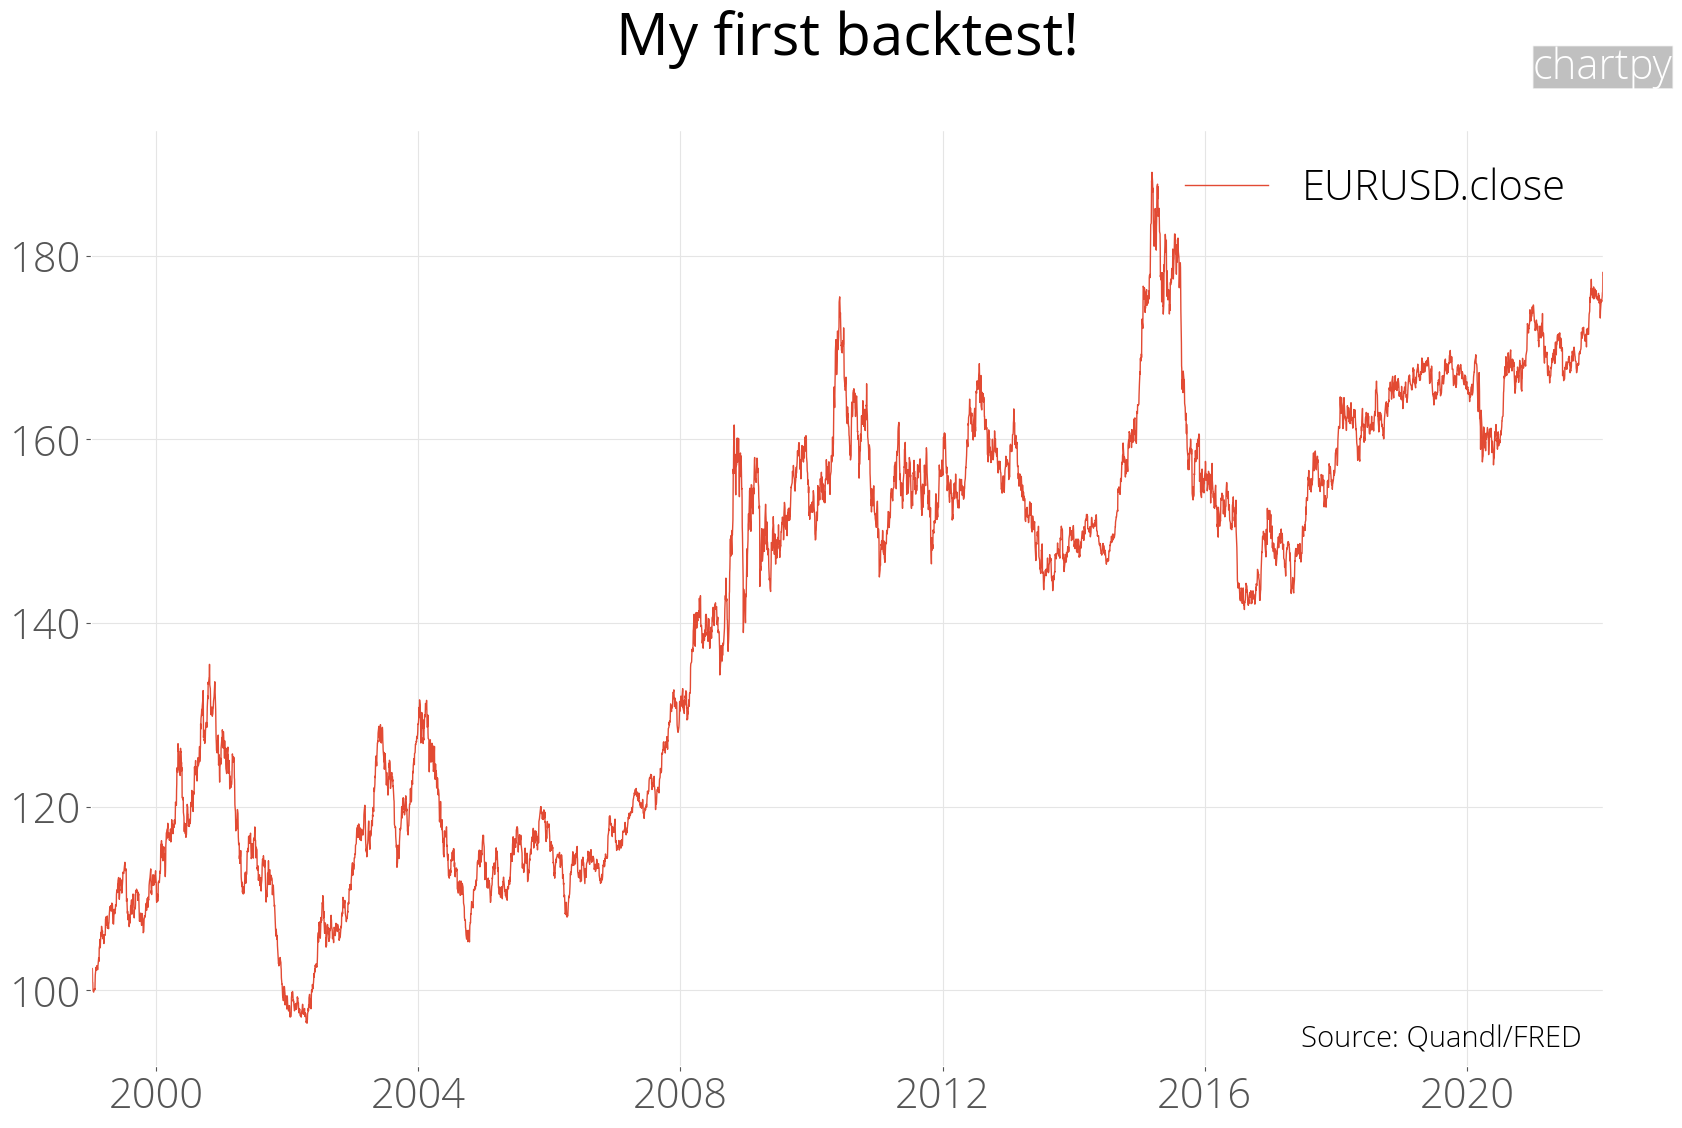

In [15]:
fx_cum_strat_ret = 100.0 * (1.0 + fx_strat_ret_df).cumprod()

Chart(engine='matplotlib').plot(fx_cum_strat_ret, 
    style=Style(title='My first backtest!', source='Quandl/FRED'));

### Backtesting a trading strategy - Part 2

#### Coding a backtest with finmarketpy

A lot of the backtest is basically repetitive, where many steps are very similar whatever signal we use:

* multiplying signals by returns
* plotting
* calculating return statistics etc.

The main differences each time are:

* parameters - like transaction costs, start and end dates etc.
* data - which data do we need for the assets we are trading? what data is being used to generate the signal?
* signal - how to construct our long and short positions

We shouldn't need to reinvent the wheel! `finmarketpy` is one of the most popular backtesting libraries on GitHub for Python, with over 2000 stars (see https://github.com/cuemacro/finmarketpy). It builds on libraries like pandas, NumPy, findatapy and chartpy. It allows us to backtest strategies relatively quickly, providing us with a large amount of boilerplate code for a trading strategy, which we need to customise for each strategy. Aside from backtesting it also has a lot of other analysis for analysing finanical markets, such as an event study tool.

#### The free hand way... to do a backtest with finmarketpy

As a first step, we do the backtest more directly with finmarketpy. We have to do all the individual calls to calculate the signals, kickstart the backtest etc. We end up using some of the lower level objects like `Backtest` and `BacktestRequest` to do this. The start of our code has all the various imports we'll need later. We also create some objects we'll need for the backtest too.

In [39]:
import datetime

from finmarketpy.backtest import Backtest, BacktestRequest
from findatapy.market import Market, MarketDataRequest, MarketDataGenerator
from findatapy.util.fxconv import FXConv
from findatapy.timeseries import Calculations

# For logging
from findatapy.util import LoggerManager

# For signal generation
from finmarketpy.economics import TechIndicator, TechParams

# For plotting
from chartpy import Chart, Style

backtest = Backtest()
br = BacktestRequest()
fxconv = FXConv()

Let's set the parameters for our backtest, such as the start date and finish date.

In [40]:
# Set all the parameters
br.start_date = "02 Jan 1999"
br.finish_date = datetime.datetime.utcnow()
br.spot_tc_bp = 2.5  # 2.5 bps bid/ask spread
br.ann_factor = 252

tech_params = TechParams()
tech_params.sma_period = 200
indicator = 'SMA'

The next step looks familar from many of the earlier examples. Here we will load the market data, but this time we use findatapy. In this case, it'll just be EUR/USD. In practice, we might want to download many different time series, as we'll often be trading a basket of different assets.

In [41]:
use_quandl = True
# use_quandl = False # Uncomment this if you don't have Quandl API key

# Pick EUR/USD
# Note: we are calculating returns from spot
# it is much better to use to total return indices for FX, which include carry
md_request = MarketDataRequest(
    start_date="01 Jan 1999",  # Start date
    finish_date=datetime.date.today(),  # Finish date
    freq='daily',  # Daily data
    data_source='quandl',  # Use Quandl as data source
    tickers=['EURUSD'],  # Ticker (findatapy)
    fields=['close'],  # Which fields to download
    vendor_tickers=['FRED/DEXUSEU'],  # Ticker (Quandl)
    vendor_fields=['close'],  # Which Bloomberg fields to download
    quandl_api_key=QUANDL_API_KEY)  # How to return data

market = Market(market_data_generator=MarketDataGenerator())

if use_quandl:
    asset_df = market.fetch_market(md_request)
else:
    asset_df = pd.read_csv(
        "https://raw.githubusercontent.com/cuemacro/" + \
        "teaching/master/pythoncourse/data/EURUSD.csv",
    index_col=0)
    
    # Convert the objects in index column to dates
    asset_df.index = pd.to_datetime(fx_df.index)
    
spot_df = asset_df

We are now getting to the actual calculation part. We create our signal, which uses a 200D SMA. Basically, when spot is above the simple moving average, we should be long, and otherwise we are short. In other words we trying to follow the long term trend. We are using finmarketpy's `TechIndicator` class, which implements a number of different technical indicators including SMA, BB (Bollinger Bands), RSI etc. It then also calculates trading signals using these technical indicators. However, we could define our own `DataFrame` of signals using totally different signals.

Then we run the backtest, by providing the asset time series (`asset_df`) and the signal time series (`signal_df`), which will be multiplied internally by the `Backtest` object. It will also do other tasks, such as take off transaction costs, and also create a cumulative index of portfolio returns.

In [42]:
# Use technical indicator to create signals
# (we could obviously create whatever function we wanted for generating the signal dataframe)
# However, finmarketpy has some technical indicators built in (and some signals too)
tech_ind = TechIndicator()
tech_ind.create_tech_ind(spot_df, indicator, tech_params);
signal_df = tech_ind.get_signal()

# use the same data for generating signals
backtest.calculate_trading_PnL(br, asset_df, signal_df, None, False)

The backtest has now finished. We can retrieve the historical returns and plot the results using chartpy (with a matplotlib backend).

            EURUSD.close SMA Signal
Date                               
2022-01-14                     -1.0
2022-01-18                     -1.0
2022-01-19                     -1.0
2022-01-20                     -1.0
2022-01-21                     -1.0
2022-01-24                     -1.0
2022-01-25                     -1.0
2022-01-26                     -1.0
2022-01-27                     -1.0
2022-01-28                     -1.0


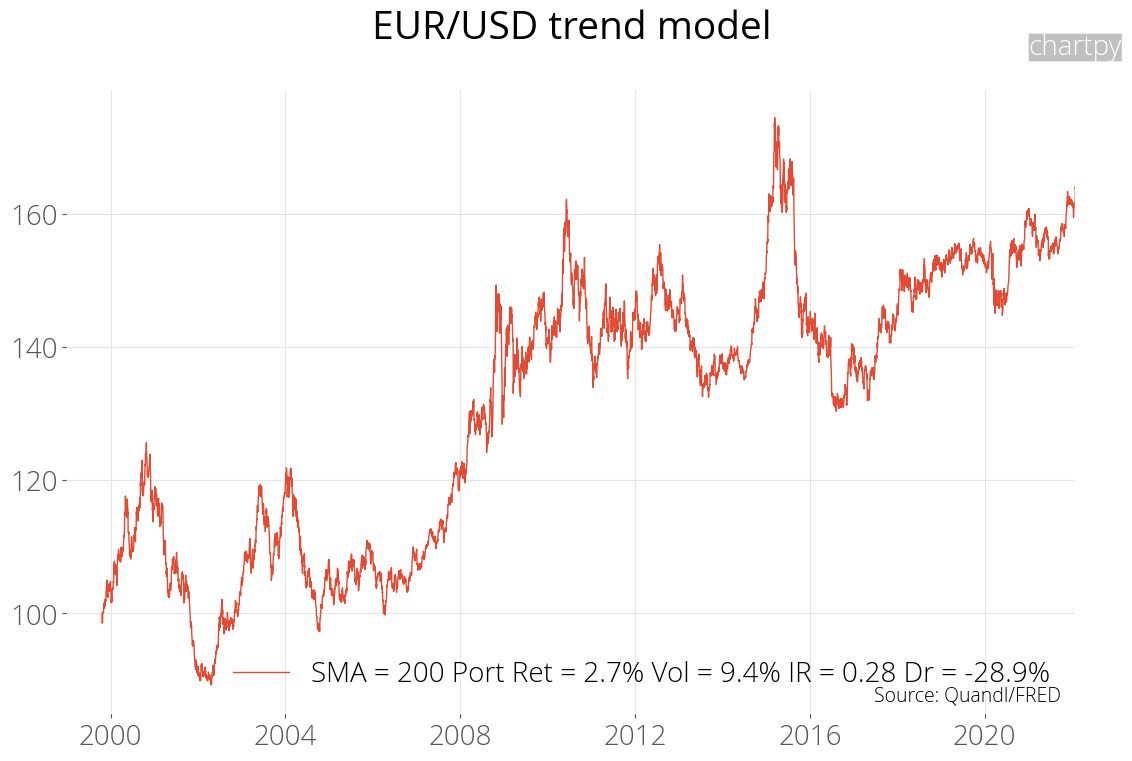

In [43]:
# Get the returns and signals for the portfolio
port = backtest.portfolio_cum() # cumulative returns index
port.columns = [indicator + ' = ' + str(tech_params.sma_period) + ' ' + str(backtest.portfolio_pnl_desc()[0])]
signals = backtest.portfolio_signal()  # get final signals for each series
returns = backtest.pnl()  # get daily P&L for each series

# Print the last few positions (we could also save as CSV etc.)
print(signals.tail(10))

style = Style(title="EUR/USD trend model", source="Quandl/FRED", scale_factor=2)

Chart(port, style=style).plot()

The results aren't too bad, but obviously, the past few years have been trading sideways. Let's try to see how a similar strategy performs with more FX crosses, and a few bells and whistles in the next section.

#### The better way to do a backtest with finmarketpy... with TradingModel - a higher level abstraction

Another way to do a backtest, is using the higher level `TradingModel` abstract class. This way we don't need to bother calling all the individual methods for calculating the signal, doing the backtest etc. It is all done in the background for us. We just need to define the parameters, signal, what data we need to do the backtest.

In our example, we will extend this class to our own implementation. The first step is to import a number of dependencies we'll need from findatapy and finmarketpy. Then we, initiantiate the class. In the `__init__` method we put in a few general parameters about the trading strategy such as its name and how we want to plot it. You can download this example from https://github.com/cuemacro/finmarketpy/blob/master/finmarketpy_examples/tradingmodelfxtrend_example.py

In [44]:
import datetime

from findatapy.market import Market, MarketDataGenerator, MarketDataRequest
from finmarketpy.backtest import TradingModel, BacktestRequest
from finmarketpy.economics import TechIndicator

from chartpy import Style

class TradingModelFXTrend_Example(TradingModel):

    def __init__(self):
        super(TradingModel, self).__init__()

        ##### FILL IN WITH YOUR OWN PARAMETERS FOR display, dumping, TSF etc.
        self.market = Market(market_data_generator=MarketDataGenerator())
        
        # Where do you want to dump any output (like charts etc?) you might need to make this folder!
        self.DUMP_PATH = 'output_data/' 
        self.FINAL_STRATEGY = 'FXTrend' # name the trading strategy
        self.SCALE_FACTOR = 1.5 # size of the charts
        
        # What plotting engine to use for charts (eg. matplotlib, plotly etc.)
        self.DEFAULT_PLOT_ENGINE = 'matplotlib' 
        # self.CHART_STYLE = Style(plotly_plot_mode='offline_jupyter')

        self.br = self.load_parameters()
        
        return

The next step is to define the `load_parameters` method, which will define when the backtest starts and finishes. Also what should our transaction costs? finmarketpy also includes some built in functionality for weighting signals according to volatility, which we'll try here. In the future, there are plans to add more complicated Python tools.

In [45]:
    ###### Parameters and signal generations (need to be customised for every model)
    def load_parameters(self, br = None):

        if br is not None: return br

        ##### FILL IN WITH YOUR OWN BACKTESTING PARAMETERS
        br = BacktestRequest()

        # Get all asset data
        br.start_date = "04 Jan 1989"
        br.finish_date = datetime.datetime.utcnow().date()
        br.spot_tc_bp = 0.5 # How much transaction costs should we include?
        br.ann_factor = 252 # How many periods in the year (252 business days)
        
        # How do we want some of plots to be done? calculate return statistics?
        # Do we want to compare against a benchmark?
        br.plot_start = "01 Jan 1989"
        br.calc_stats = True
        br.write_csv = False
        br.plot_interim = True
        br.include_benchmark = True

        # Have vol target for each signal?
        # Higher volatility assets will have a smaller notional
        # Lower volatility assets will have a larger notional
        # the idea is we have the same amount of "risk" in each
        br.signal_vol_adjust = True
        br.signal_vol_target = 0.1 # Vol target is 10% annualised
        br.signal_vol_max_leverage = 5 # Max leverage we can have is 5x per signal
        br.signal_vol_periods = 20 # When calculating realised vol, use a 20D window
        br.signal_vol_obs_in_year = 252 # There are 252 business days in a year
        br.signal_vol_rebalance_freq = 'BM' # Rebalance the leverage at every month end
        br.signal_vol_resample_freq = None

        # Have vol target for portfolio
        # Make sure the portfolio has the leverage adjusted using vol of returns
        # This should hopefully smooth our returns over time
        br.portfolio_vol_adjust = True
        br.portfolio_vol_target = 0.1
        br.portfolio_vol_max_leverage = 5
        br.portfolio_vol_periods = 20
        br.portfolio_vol_obs_in_year = 252
        br.portfolio_vol_rebalance_freq = 'BM'
        br.portfolio_vol_resample_freq = None

        # Tech params
        br.tech_params.sma_period = 200

        return br

The next step is to load up our market data in pandas `DataFrame` objects. We are using findatapy to download FX spot data from Quandl. We could use other libraries to download the data provided they can generate `DataFrame`

In [46]:
    def load_assets(self, br=None):
        
        use_quandl = True
        # use_quandl = False # Uncomment if you don't have a Quandl API Key
        
        ##### FILL IN WITH YOUR ASSET DATA
        from findatapy.util.loggermanager import  LoggerManager
        logger = LoggerManager().getLogger(__name__)

        # for FX basket
        full_bkt = ['EURUSD', 'USDJPY', 'GBPUSD', 'AUDUSD', 
                    'USDCAD', 'NZDUSD', 'USDCHF', 'USDNOK', 'USDSEK']

        basket_dict = {}

        # We want to calculate returns for each individual asset
        for i in range(0, len(full_bkt)):
            basket_dict[full_bkt[i]] = [full_bkt[i]]
        
        # Create a basket including all currency pairs
        basket_dict['FXTrend'] = full_bkt
        
        # Get the parameters for backtest
        br = self.load_parameters(br=br)

        logger.info("Loading asset data...")
        
        # Vendor tickers for Quandl for the above currency pairs
        vendor_tickers = ['FRED/DEXUSEU', 'FRED/DEXJPUS', 'FRED/DEXUSUK', 'FRED/DEXUSAL', 
                          'FRED/DEXCAUS', 'FRED/DEXUSNZ', 'FRED/DEXSZUS', 'FRED/DEXNOUS', 
                          'FRED/DEXSDUS']

        market_data_request = MarketDataRequest(
                    start_date = br.start_date,             # Start date
                    finish_date = br.finish_date,           # Finish date
                    freq = 'daily',                         # Daily data
                    data_source = 'quandl',                 # Use Quandl as data source
                    tickers = full_bkt,                     # Ticker (Cuemacro)
                    fields = ['close'],                     # Which fields to download
                    vendor_tickers = vendor_tickers,        # Ticker (Quandl)
                    vendor_fields = ['close'],              # Which vendor fields to download
                    quandl_api_key=QUANDL_API_KEY)          # API key
        
        if use_quandl:
            asset_df = self.market.fetch_market(market_data_request)
            asset_df.to_csv(raw_data_path + 'daily_fx_spot_data.csv')
        else:
            import pandas
            
            url = "https://raw.githubusercontent.com/cuemacro/teaching/master/" + \
                "pythoncourse/data/daily_fx_spot_data.csv"
            asset_df = pandas.read_csv(
                url, index_col=0, parse_dates=['Date'],
                date_parser = lambda x: pandas.datetime.strptime(x, '%Y-%m-%d'))

        # Signalling variables also use the same time series
        # Note, we could have a different dataset to construct the signal
        # eg. interest rates, economic data, not necessarily FX data
        spot_df = asset_df
        spot_df2 = None
         
        # These DataFrames will be used later
        
        # asset_df - used to calculate asset returns later
        # spot_df & spot_df2 - used by construct_signal
        return asset_df, spot_df, spot_df2, basket_dict

We can now define how to construct the signal. This looks pretty similar to our previous example using `TechIndicator`... That's because it's exactly the same trading rule!

In [47]:
    def construct_signal(self, spot_df, spot_df2, tech_params, br, run_in_parallel=False):

        ##### FILL IN WITH YOUR OWN SIGNALS

        # Use technical indicator to create signals
        # We could obviously create whatever function we wanted 
        # For generating the signal dataframe
        tech_ind = TechIndicator()
        tech_ind.create_tech_ind(spot_df, 'SMA', tech_params);
        signal_df = tech_ind.get_signal()

        return signal_df

Lastly we define a benchmark to judge the signal. In this case, we are using EUR/USD. It is likely that we'd use other benchmarks, in particular, S&P500. FX is  a bit unusual, in that we don't have a commonly agreed beta/benchmark to use. In practice, we use proxy benchmarks in FX, which are similar to typical strategies employed in the market, such as carry, trend and value. For a discussion of FX market beta (see https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2439854).

In [48]:
     def construct_strategy_benchmark(self):

        ###### FILL IN WITH YOUR OWN BENCHMARK
        tsr_indices = MarketDataRequest(
            start_date = self.br.start_date,    # Start date
            finish_date = self.br.finish_date,  # Finish date
            freq = 'daily',                     # Daily data
            data_source = 'quandl',             # Use Quandl as data source
            tickers = ["EURUSD"],               # Tickers to download
            vendor_tickers=['FRED/DEXUSEU'],
            fields = ['close'],                 # Which fields to download
            vendor_fields = ['close'],
            quandl_api_key=QUANDL_API_KEY)      # API key

        df = self.market.fetch_market(tsr_indices)

        df.columns = [x.split(".")[0] for x in df.columns]

        return df

We now need to do the below step, because we have filled in each method in a seperate cell in Jupyter notebook. You wouldn't need to do this if you writing this in a separate Python script.

In [49]:
TradingModelFXTrend_Example.load_parameters = load_parameters
TradingModelFXTrend_Example.load_assets = load_assets
TradingModelFXTrend_Example.construct_signal = construct_signal
TradingModelFXTrend_Example.construct_strategy_benchmark = construct_strategy_benchmark

Ok, we've now implemented all the methods in `TradingModelFXTrend_Example`. The next step is to instiantiate the model and kick off the backtest by running `construct_strategy`. This method will then in turn construct all the individual strategies, creating the signals (via `construct_signal`). This will take a while, mostly because of the time taken to download the data, rather than CPU processing.

In [50]:
model = TradingModelFXTrend_Example()

model.construct_strategy()

#### Plotting backtest results

We can also plot some of the results...

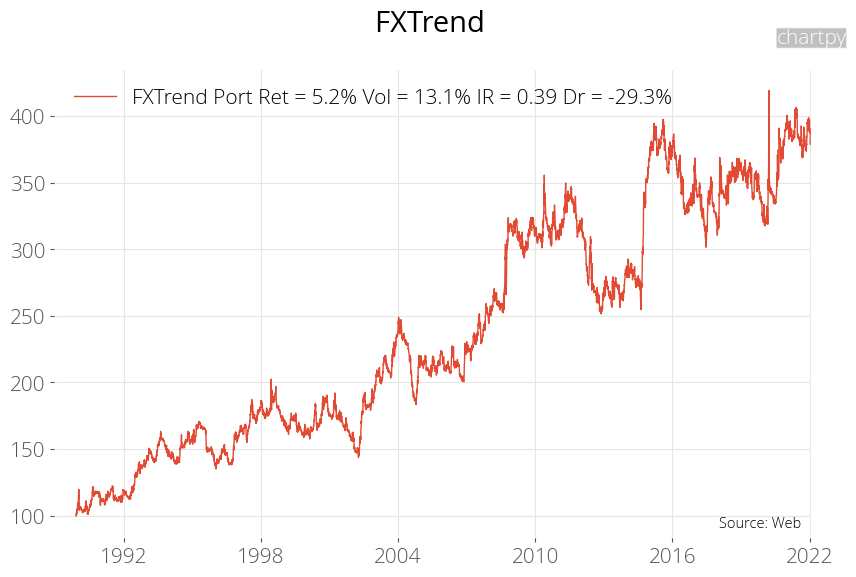

In [51]:
model.plot_strategy_pnl()

Plot the leverage used at the portfolio level.

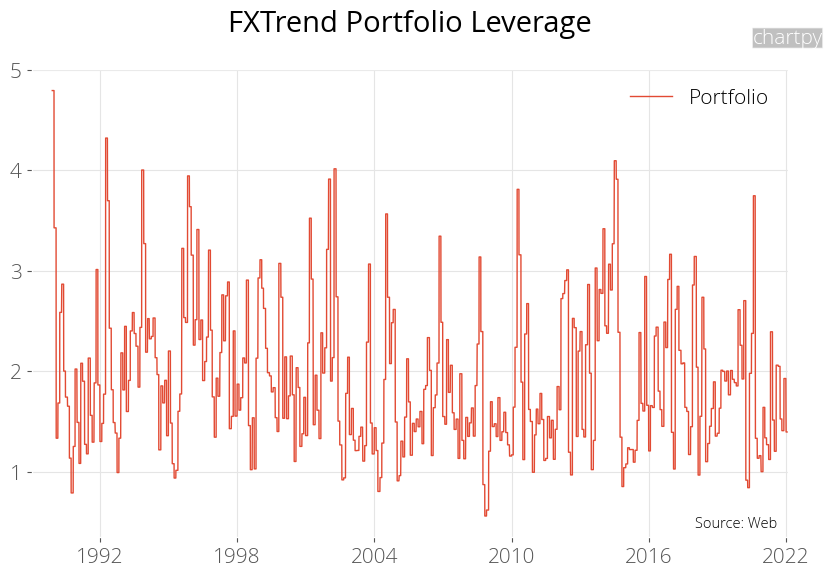

In [52]:
model.plot_strategy_leverage();

Plot the P&L of individual trades for each currency pair.

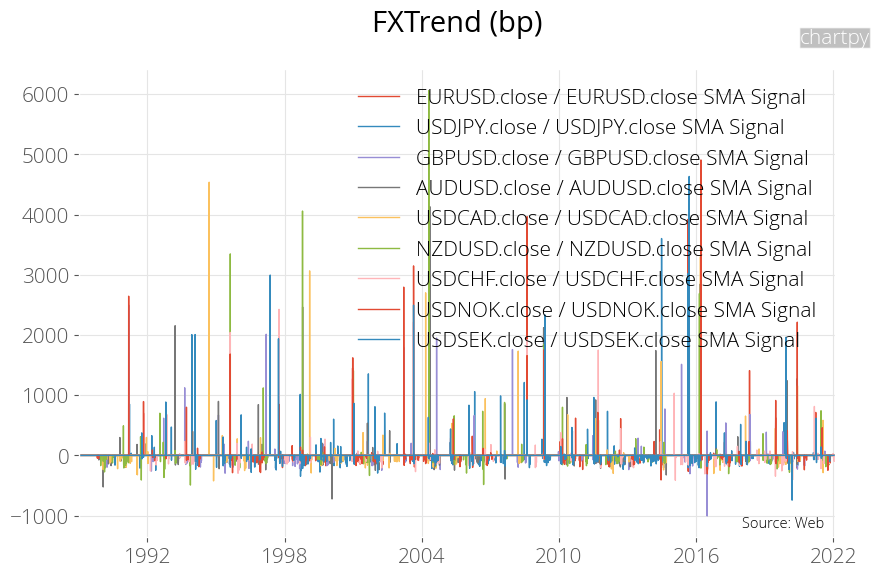

In [53]:
model.plot_strategy_group_pnl_trades();

Plot the P&L of each currency pair and the portfolio separately.

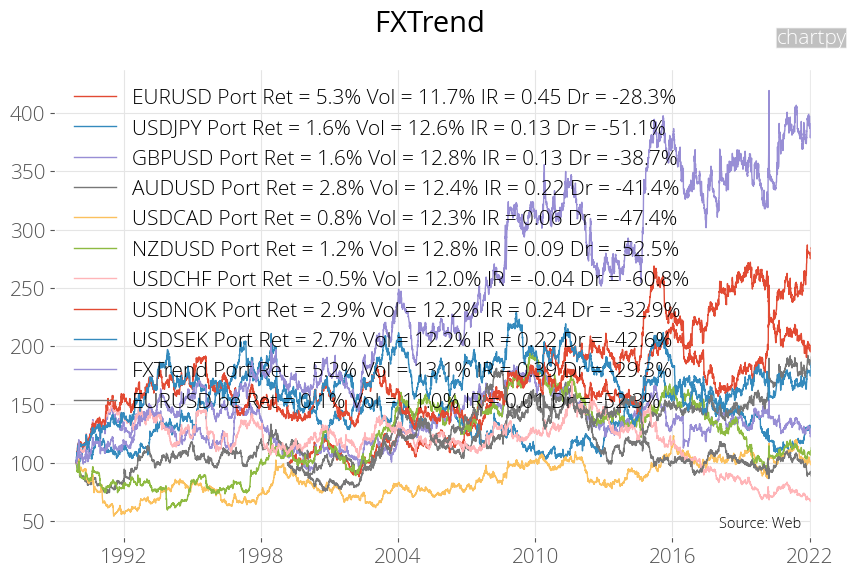

In [54]:
model.plot_strategy_group_benchmark_pnl();

Plot the risk adjusted returns for each currency pair and the portfolio when backtesting our trend following rule.

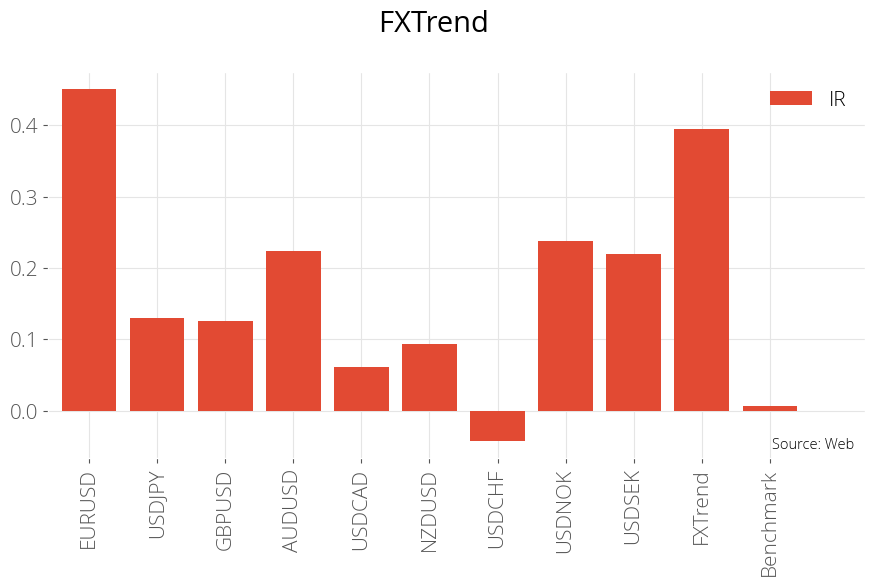

In [55]:
model.plot_strategy_group_benchmark_pnl_ir();

We can display a summary of the results in a webpage format by using the `TradeAnalysis` object. This will open up our browser with a summary page.

In [56]:
from finmarketpy.backtest import TradeAnalysis

ta = TradeAnalysis()

ta.run_strategy_returns_stats(model, engine='finmarketpy')

#### Sensitivity analysis of backtest

`TradeAnalysis` also allows us to do sensitivity analysis on our backtest. Below we run our backtest with and without adjusting the notional of signals and portfolio for volatility. It clearly makes a big difference, not only in terms of the returns (which we would expect), but also risk adjusted returns. The trend following, clearly, it's not just the signal. This is true of many strategies, the signal in isolation is not the only thing which contributes to improving returns.

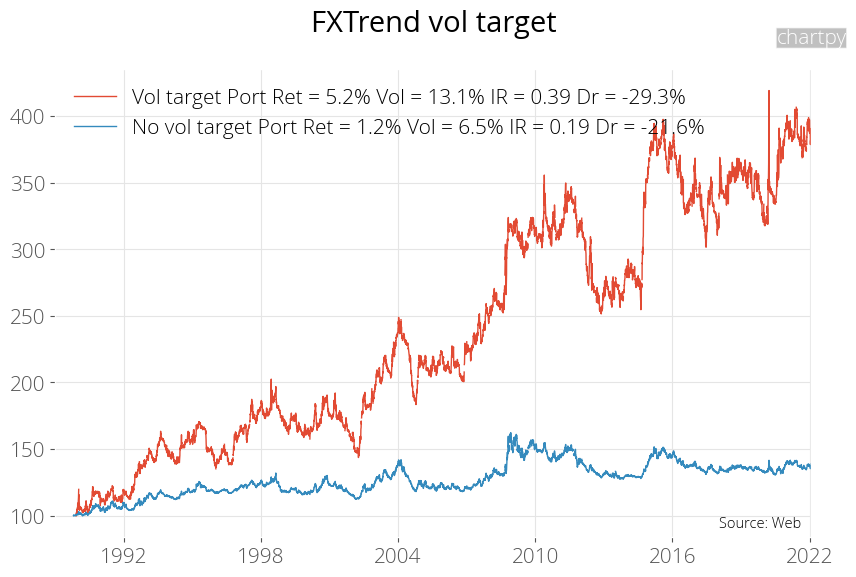

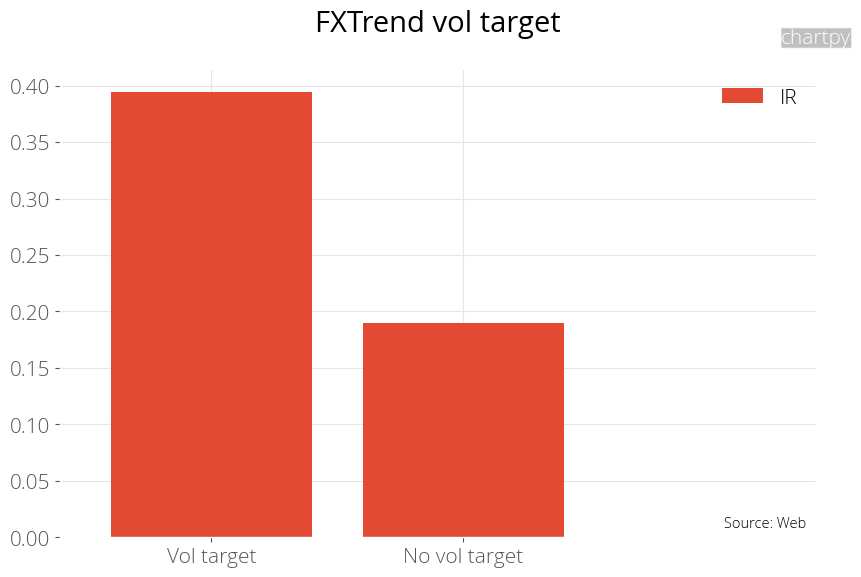

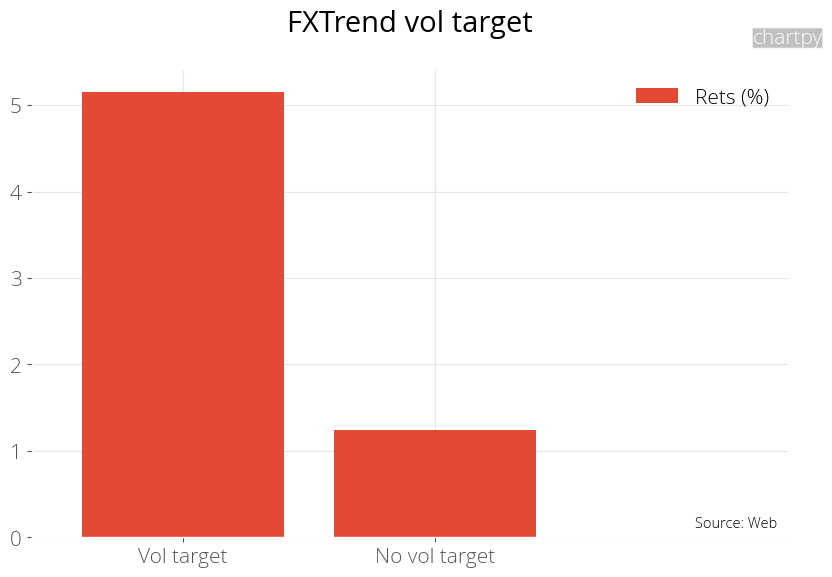

In [57]:
parameter_list = [
            {'portfolio_vol_adjust': True, 'signal_vol_adjust' : True},
            {'portfolio_vol_adjust': False, 'signal_vol_adjust' : False}]

pretty_portfolio_names = \
            ['Vol target',
             'No vol target']

parameter_type = 'vol target'

ta.run_arbitrary_sensitivity(model,
    parameter_list=parameter_list,
    pretty_portfolio_names=pretty_portfolio_names,
    parameter_type=parameter_type);

Another common question we might want to ask is the impact of different transaction costs on our strategy. This has it's own specific method in `TradeAnalysis` given that this is likely to be a very common task.

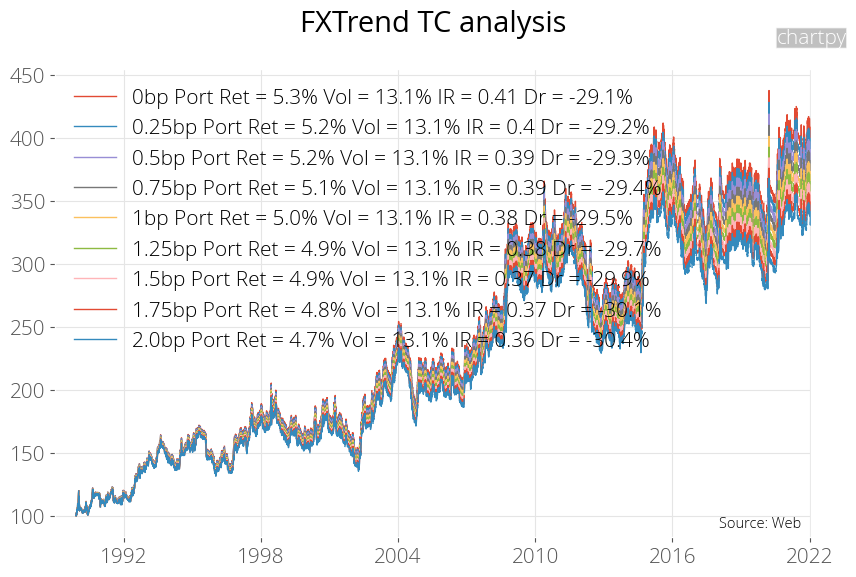

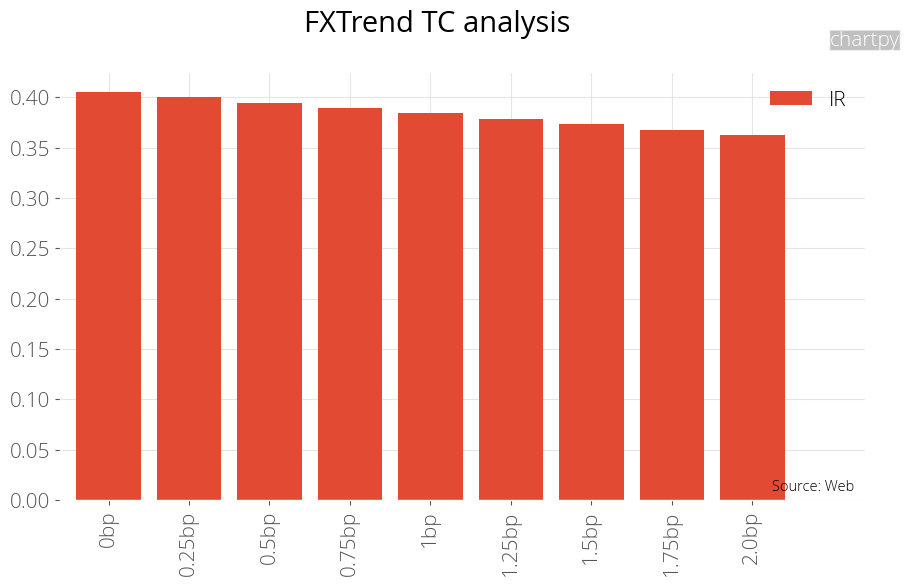

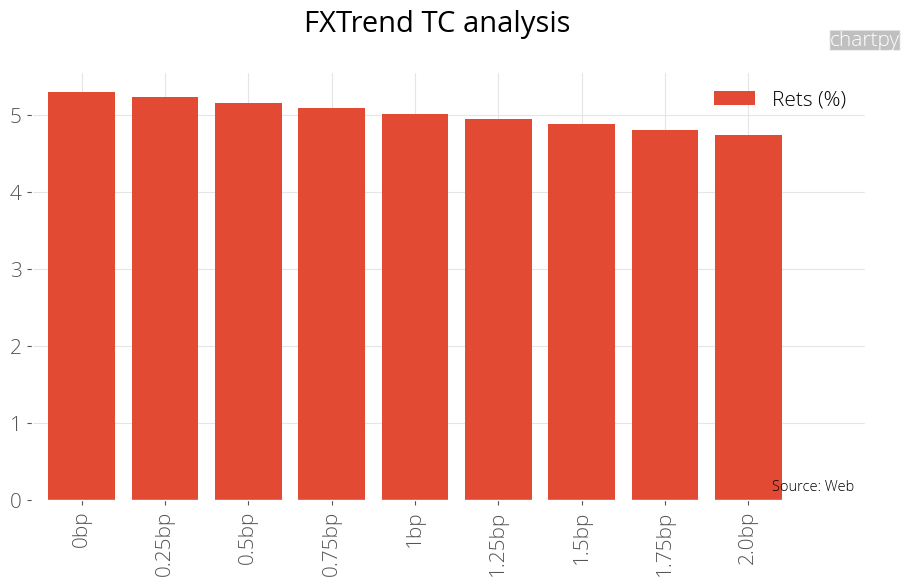

In [58]:
tc = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2.0]
ta.run_tc_shock(model, tc=tc);

There are other built in analysis we can apply using `TradeAnalysis` such as checking how strategy returns are accumulated throughout each month (does it make money towards the beginning of the month or towards the end of it).

## Tutorial: Analysis of financial data

It's now time to do your own analysis of financial markets with Python. Note, that to get data from Quandl, you'll need a free Quandl API key (see https://docs.quandl.com/docs#section-authentication).

### Downloading market data from Yahoo and returns calculations

* Download market data for Apple and Tesla stock from Yahoo from 2001-2020
* Calculate the monthly returns for each stock
* Select only 2019 monthly returns
* Plot the monthly returns as a bar chart and then as a line chart
* Do the same thing for annual data for the full sample
* Plot daily time series of Apple and Tesla stock from 2011 onwards
    * This makes it easier to compare relative performance
    * Rebase each time series so it starts from 100

### Relationship between US stocks and US growth

* Download data for S&P500 (or Dow Jones Industrial Average) for United States and US GDP (from ALFRED/FRED) for as long as the history goes back. Should be many decades for both time series.
* Calculate quarter on quarter % changes for US GDP and quarterly returns for S&P500
* Plot the time series of both 
* Do a scatter plot of both with chartpy (and plot line of best fit with chartpy)
* If you have time, use scikit-learn or statsmodels to do a contemporaneous linear regression of the two variables (ie. regress Q1 changes in US GDP vs. Q1 returns for S&P500) using a training set
    * Use GDP quarter-on-quarter changes as your $x$ value and S&P500 quarterly returns as your $y$ value to be predicted
    * Keep the last 4 years as a test set
* You can also try using DJIA instead of S&P500

### Create your own trading strategy

* Download FX data from Quandl for EUR/USD (either using the Quandl library or findatapy)
* Come up with a signal for your trading strategy
    * Trend? Whatever you want?!
    * Try using different technical indicators (eg. Bollinger bands, or whatever you'd like)
    * You can implement technical indicatiors directly using Pandas (we showed how to a simple moving average earlier with Pandas) or you can use another library which has built-in technical indciators using finmarketpy
    * Using the technical indicator you need to create a trading signal (ie. +1 or -1)
* Implement a backtest using Pandas
* Visualise the returns with Matplotlib (or Plotly)
* How do the results change, when you change the parameters?
* For simplicity assume that spot returns are the same as total returns
* Also try implementing the same backtest in finmarketpy and try it with other currency pairs too if you have time.

### If you have more time left... can do an FX example of the first exercise

* Download market data for EUR/USD, USD/JPY, GBP/USD from Quandl between 2000-2019 using findatapy or using Quandl API directly
* Invert USD/JPY (ie. JPY/USD)
* Calculate the daily returns of each time series in the dataset
* Make 2000-2018 returns, the training set and 2019 the test set for returns
* Plot the training set returns of each time series for 2018 (will look quite noisy!)
* Do a linear regression between in the training set with scikit-learn or statsmodels with $y$ variable as GBP/USD daily returns and the $x$ variables as JPY/USD and EUR/USD
* Using these coefficients, do a scatter plot of the expected output of GBP/USD returns vs. actual GBP/USD returns in the test set (ie. 2019)